Berry Phase (Figure-8): 0.2447 radians
Berry Phase (Figure-8 rev): 0.7855 radians
Berry Phase (Circle): 3.1099 radians
Berry Phase (Sphere): 3.1416 radians
Berry Phase (Tilted Circle): 0.9105 radians


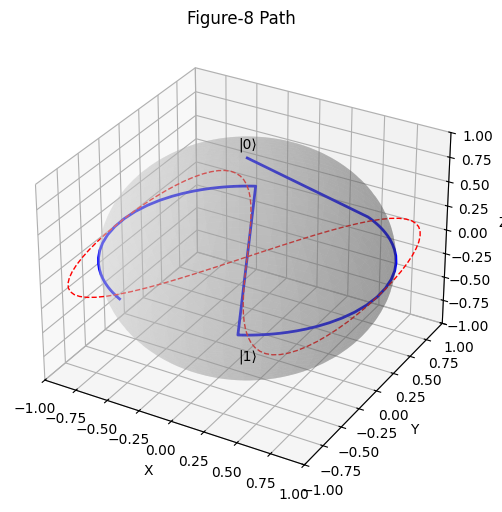

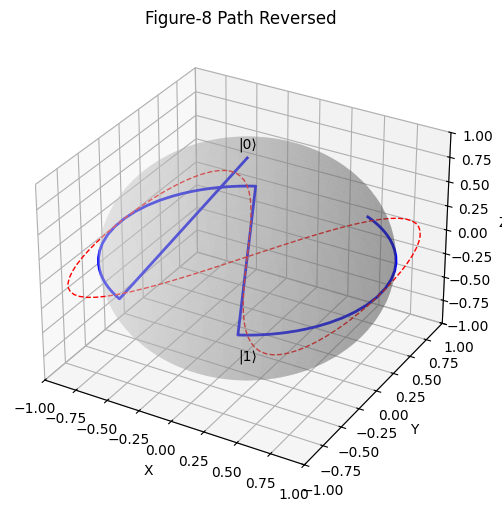

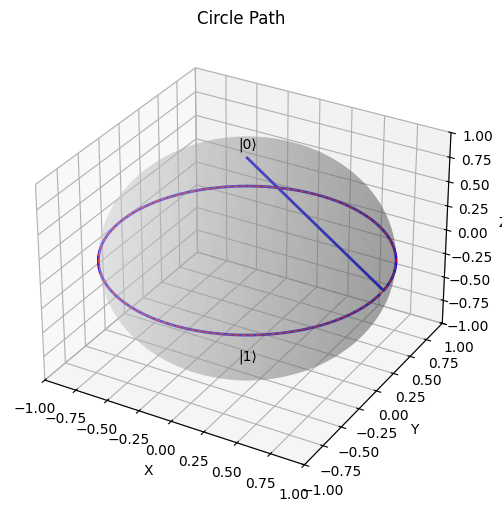

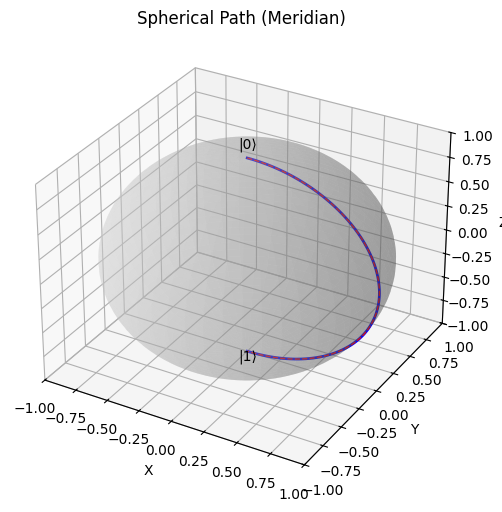

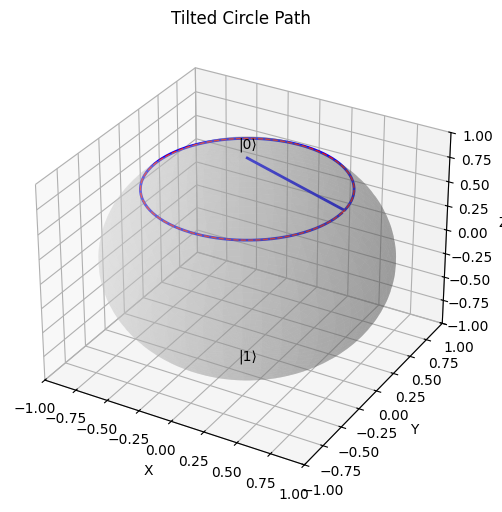

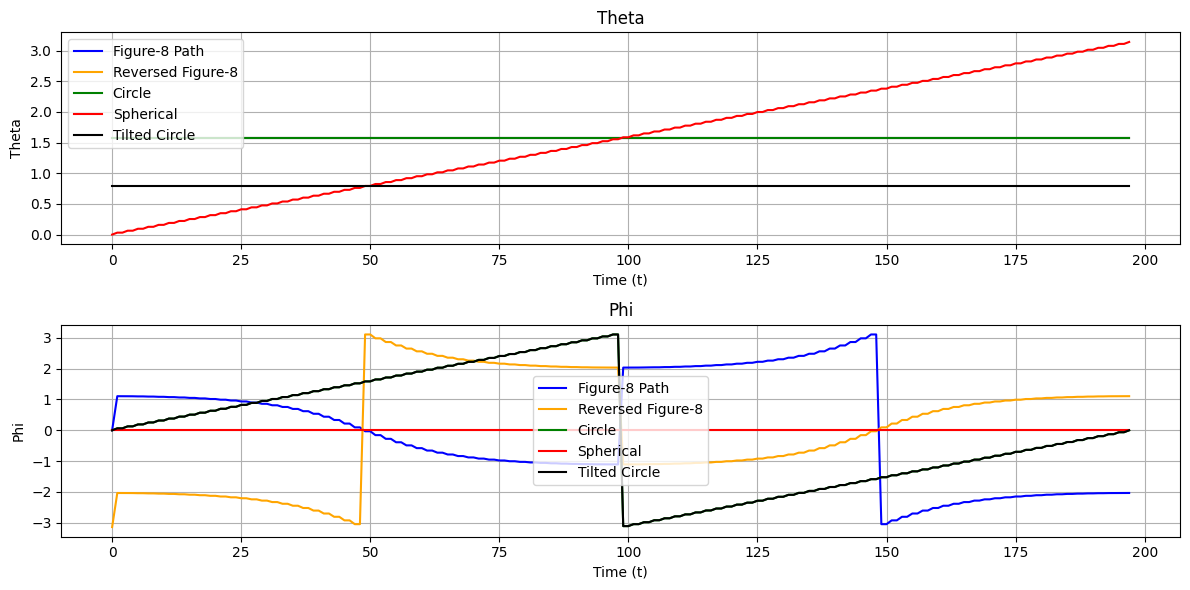

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- SU(2) Rotation Utilities ---
def pauli_matrices():
    sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
    return sigma_x, sigma_y, sigma_z

def su2_rotation(theta, n):
    """
    Generates the SU(2) rotation matrix.
    
    Args:
        theta: Rotation angle (in radians).
        n: Rotation axis (unit vector).
        
    Returns:
        SU(2) rotation matrix (2x2 complex array).
    """
    sigma_x, sigma_y, sigma_z = pauli_matrices()
    n_dot_sigma = n[0] * sigma_x + n[1] * sigma_y + n[2] * sigma_z
    rotation_matrix = np.cos(theta / 2) * np.identity(2) - 1j * np.sin(theta / 2) * n_dot_sigma
    return rotation_matrix

def rotate_spinor(spinor, theta, n):
    """Rotates a spinor using the SU(2) rotation matrix."""
    rotation_matrix = su2_rotation(theta, n)
    return np.dot(rotation_matrix, spinor)

def spinor(theta, phi):
    """Creates a spinor given spherical coordinates."""
    return np.array([np.cos(theta/2), np.exp(1j*phi)*np.sin(theta/2)], dtype=complex)

def bloch_vector(spinor):
    """Calculates the Bloch vector from a spinor."""
    sigma_x, sigma_y, sigma_z = pauli_matrices()
    x = np.real(np.vdot(spinor, np.dot(sigma_x, spinor)))
    y = np.real(np.vdot(spinor, np.dot(sigma_y, spinor)))
    z = np.real(np.vdot(spinor, np.dot(sigma_z, spinor)))
    return np.array([x, y, z])

def berry_phase(spinors):
    """Calculates the Berry phase for a sequence of spinors."""
    phase = 0.0
    for i in range(len(spinors) - 1):
        phase += np.imag(np.log(np.vdot(spinors[i], spinors[i+1])))
    # The last spinor connects with the first.
    phase += np.imag(np.log(np.vdot(spinors[-1], spinors[0])))
    return phase

def simulate_path(path_func, num_points=100):
    """Simulates spinor evolution along a given path.

    Args:
      path_func: Function that returns (x,y,z) coordinates and the
                 rotation axis (nx, ny, nz) for a given parameter t.
      num_points: Number of points to sample along the path.

    Returns:
      Tuple: (spinors, bloch_vectors, thetas, phis)
    """
    t_values = np.linspace(0, 1, num_points)  # Parameterize the path
    initial_spinor = spinor(0, 0)  # Start with spinor pointing along +z
    spinors = [initial_spinor]
    bloch_vectors = [bloch_vector(initial_spinor)]
    thetas = []
    phis = []

    for i in range(1, num_points):
        t_prev = t_values[i-1]
        t_curr = t_values[i]

        # Get path coordinates and rotation axis at previous and current points
        x_prev, y_prev, z_prev, nx_prev, ny_prev, nz_prev = path_func(t_prev)
        x_curr, y_curr, z_curr, nx_curr, ny_curr, nz_curr = path_func(t_curr)

        # Convert path coordinates to spherical coordinates for the axis (for logging)
        theta_prev = np.arccos(z_prev)
        phi_prev = np.arctan2(y_prev, x_prev)
        thetas.append(theta_prev)
        phis.append(phi_prev)

        theta_curr = np.arccos(z_curr)
        phi_curr = np.arctan2(y_curr, x_curr)
        thetas.append(theta_curr)
        phis.append(phi_curr)

        # Use the provided rotation axis from the path function
        n_prev = np.array([nx_prev, ny_prev, nz_prev], dtype=float)
        n_curr = np.array([nx_curr, ny_curr, nz_curr], dtype=float)
        n_prev = n_prev / np.linalg.norm(n_prev) if np.linalg.norm(n_prev) != 0 else n_prev
        n_curr = n_curr / np.linalg.norm(n_curr) if np.linalg.norm(n_curr) != 0 else n_curr

        # Determine the infinitesimal rotation between Bloch vectors.
        bv_prev = bloch_vectors[-1]
        # Construct the current Bloch vector from spherical coordinates
        bv_curr = np.array([np.sin(theta_curr)*np.cos(phi_curr),
                            np.sin(theta_curr)*np.sin(phi_curr),
                            np.cos(theta_curr)])
        rotation_axis = np.cross(bv_prev, bv_curr)
        if np.linalg.norm(rotation_axis) != 0:  # Normalize if not a zero vector
            rotation_axis = rotation_axis / np.linalg.norm(rotation_axis)
        rotation_angle = np.arccos(np.clip(np.dot(bv_prev, bv_curr), -1.0, 1.0))
        
        # Rotate the spinor and update lists
        rotated_spinor = rotate_spinor(spinors[-1], rotation_angle, rotation_axis)
        spinors.append(rotated_spinor)
        bloch_vectors.append(bloch_vector(rotated_spinor))

    return spinors, bloch_vectors, thetas, phis

# --- Path Definitions ---
def figure_8_path(t):
    """Original figure-8 path."""
    x = np.sin(2 * np.pi * t)
    y = np.sin(4 * np.pi * t)
    z = 0.0  # In the x-y plane
    nx, ny, nz = 0, 0, 1  # Rotation axis along z
    return x, y, z, nx, ny, nz

def figure_8_path_rev(t):
    """Reversed figure-8 path."""
    x = np.sin(-2 * np.pi * t)
    y = np.sin(-4 * np.pi * t)
    z = 0.0  # In the x-y plane
    nx, ny, nz = 0, 0, 1  # Rotation axis along z
    return x, y, z, nx, ny, nz

def circle_path(t):
    """Circular path in the x-y plane."""
    radius = 1.0
    x = radius * np.cos(2 * np.pi * t)
    y = radius * np.sin(2 * np.pi * t)
    z = 0.0
    nx, ny, nz = 0, 0, 1  # Rotation axis along z
    return x, y, z, nx, ny, nz

def spherical_path(t):
    """Path along a meridian of the Bloch sphere."""
    theta = np.pi * t  # From north to south pole
    phi = 0.0          # Constant azimuth
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    nx, ny, nz = 0, 1, 0  # Rotation axis along y
    return x, y, z, nx, ny, nz

def tilted_circle_path(t):
    """Circular path tilted with respect to the z-axis."""
    theta = 2 * np.pi * t
    phi = np.pi / 4  # Constant tilt angle
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    # Compute rotation axis perpendicular to the circle's plane
    nx = -np.sin(phi) * np.sin(theta)
    ny = np.sin(phi) * np.cos(theta)
    nz = np.cos(phi)
    norm = np.sqrt(nx**2 + ny**2 + nz**2)
    nx, ny, nz = nx/norm, ny/norm, nz/norm
    return x, y, z, nx, ny, nz

# --- Main Simulation and Plotting ---
# Simulate different paths
spinors_fig8, bloch_vectors_fig8, thetas_fig8, phis_fig8 = simulate_path(figure_8_path)
spinors_fig8_rev, bloch_vectors_fig8_rev, thetas_fig8_rev, phis_fig8_rev = simulate_path(figure_8_path_rev)
spinors_circle, bloch_vectors_circle, thetas_circle, phis_circle = simulate_path(circle_path)
spinors_sphere, bloch_vectors_sphere, thetas_sphere, phis_sphere = simulate_path(spherical_path)
spinors_tilted, bloch_vectors_tilted, thetas_tilted, phis_tilted = simulate_path(tilted_circle_path)

# Calculate Berry phases
berry_phase_fig8     = berry_phase(spinors_fig8)
berry_phase_fig8_rev = berry_phase(spinors_fig8_rev)
berry_phase_circle   = berry_phase(spinors_circle)
berry_phase_sphere   = berry_phase(spinors_sphere)
berry_phase_tilted   = berry_phase(spinors_tilted)

print(f"Berry Phase (Figure-8): {berry_phase_fig8:.4f} radians")
print(f"Berry Phase (Figure-8 rev): {berry_phase_fig8_rev:.4f} radians")
print(f"Berry Phase (Circle): {berry_phase_circle:.4f} radians")
print(f"Berry Phase (Sphere): {berry_phase_sphere:.4f} radians")
print(f"Berry Phase (Tilted Circle): {berry_phase_tilted:.4f} radians")

def plot_bloch_sphere(bloch_vectors, title, path_xyz=None):
    """Plots the Bloch sphere and the trajectory of the Bloch vector."""
    # Convert list to a NumPy array for slicing
    bloch_vectors = np.array(bloch_vectors)
    
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Draw the Bloch sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(xs, ys, zs, color='lightgray', alpha=0.3)

    # Plot the Bloch vector trajectory
    ax.plot(bloch_vectors[:, 0], bloch_vectors[:, 1], bloch_vectors[:, 2],
            color='blue', linewidth=2)
    
    # Plot the provided path if any
    if path_xyz is not None:
        ax.plot(path_xyz[:, 0], path_xyz[:, 1], path_xyz[:, 2],
                color='red', linestyle='dashed', linewidth=1)

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.text(0, 0, 1.1, "|0⟩", ha='center')  # North pole
    ax.text(0, 0, -1.1, "|1⟩", ha='center') # South pole
    plt.show()

# Create path_xyz arrays for plotting
path_xyz_fig8     = np.array([figure_8_path(t)[:3] for t in np.linspace(0, 1, 100)])
path_xyz_fig8_rev = np.array([figure_8_path_rev(t)[:3] for t in np.linspace(0, 1, 100)])
path_xyz_circle   = np.array([circle_path(t)[:3] for t in np.linspace(0, 1, 100)])
path_xyz_sphere   = np.array([spherical_path(t)[:3] for t in np.linspace(0, 1, 100)])
path_xyz_tilted   = np.array([tilted_circle_path(t)[:3] for t in np.linspace(0, 1, 100)])

# Plot Bloch sphere trajectories
plot_bloch_sphere(bloch_vectors_fig8, "Figure-8 Path", path_xyz_fig8)
plot_bloch_sphere(bloch_vectors_fig8_rev, "Figure-8 Path Reversed", path_xyz_fig8_rev)
plot_bloch_sphere(bloch_vectors_circle, "Circle Path", path_xyz_circle)
plot_bloch_sphere(bloch_vectors_sphere, "Spherical Path (Meridian)", path_xyz_sphere)
plot_bloch_sphere(bloch_vectors_tilted, "Tilted Circle Path", path_xyz_tilted)

# Plot theta and phi values
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(thetas_fig8, label='Figure-8 Path', color='blue')
plt.plot(thetas_fig8_rev, label='Reversed Figure-8', color='orange')
plt.plot(thetas_circle, label='Circle', color='green')
plt.plot(thetas_sphere, label='Spherical', color='red')
plt.plot(thetas_tilted, label='Tilted Circle', color='black')
plt.title('Theta')
plt.xlabel('Time (t)')
plt.ylabel('Theta')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(phis_fig8, label='Figure-8 Path', color='blue')
plt.plot(phis_fig8_rev, label='Reversed Figure-8', color='orange')
plt.plot(phis_circle, label='Circle', color='green')
plt.plot(phis_sphere, label='Spherical', color='red')
plt.plot(phis_tilted, label='Tilted Circle', color='black')
plt.title('Phi')
plt.xlabel('Time (t)')
plt.ylabel('Phi')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



Fidelity Results:
Fidelity for Original Path: 1.00000000000000000000000000000000
Fidelity for Reversed Path: 1.00000000000000000000000000000000
Fidelity for Clockwise Path: 1.00000000000000000000000000000000
Fidelity for Counterclockwise Path: 1.00000000000000000000000000000000



Results for Original Path:
Berry Phase: 0.00000000000000000000000000000000 rad
Berry Phase (degrees): 0.00000000000000000000000000000000°
Angle Difference between Initial and Final Spinor: 0.00000000000000000000000000000000 rad
Average Normalization: 1.00000000000000000000000000000000
Average Uncertainty: 0.48887401127716306747927887954575
Normalization Check: PASSED (Max Deviation: 0.0000000000000002)
Uncertainty Principle Check: FAILED (Average Uncertainty: 0.48887401127716306747927887954575)

Results for Reversed Path:
Berry Phase: 0.00000000000000000000000000000000 rad
Berry Phase (degrees): 0.00000000000000000000000000000000°
Angle Difference between Initial and Final Spinor: 0.00000000000000000000000000000000 rad
Average Normalization: 1.00000000000000000000000000000000
Average Uncertainty: 0.48887401127716306747927887954575
Normalization Check: PASSED (Max Deviation: 0.0000000000000002)
Uncertainty Principle Check: FAILED (Average Uncertainty: 0.48887401127716306747927887954575

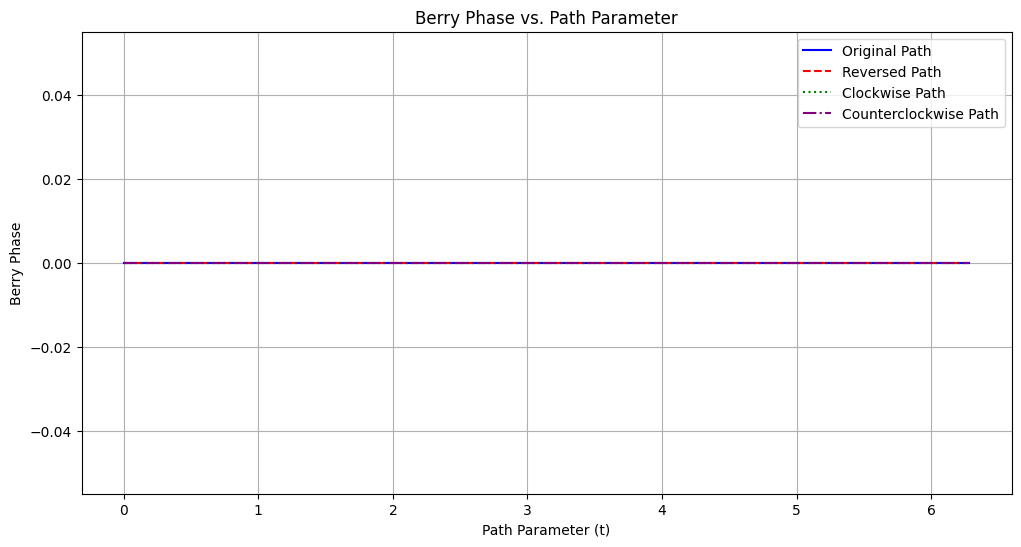

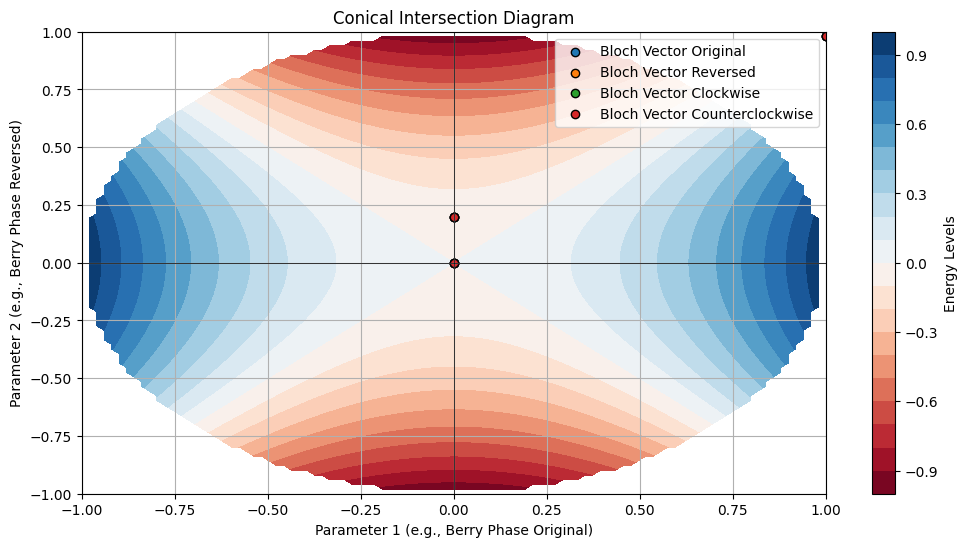

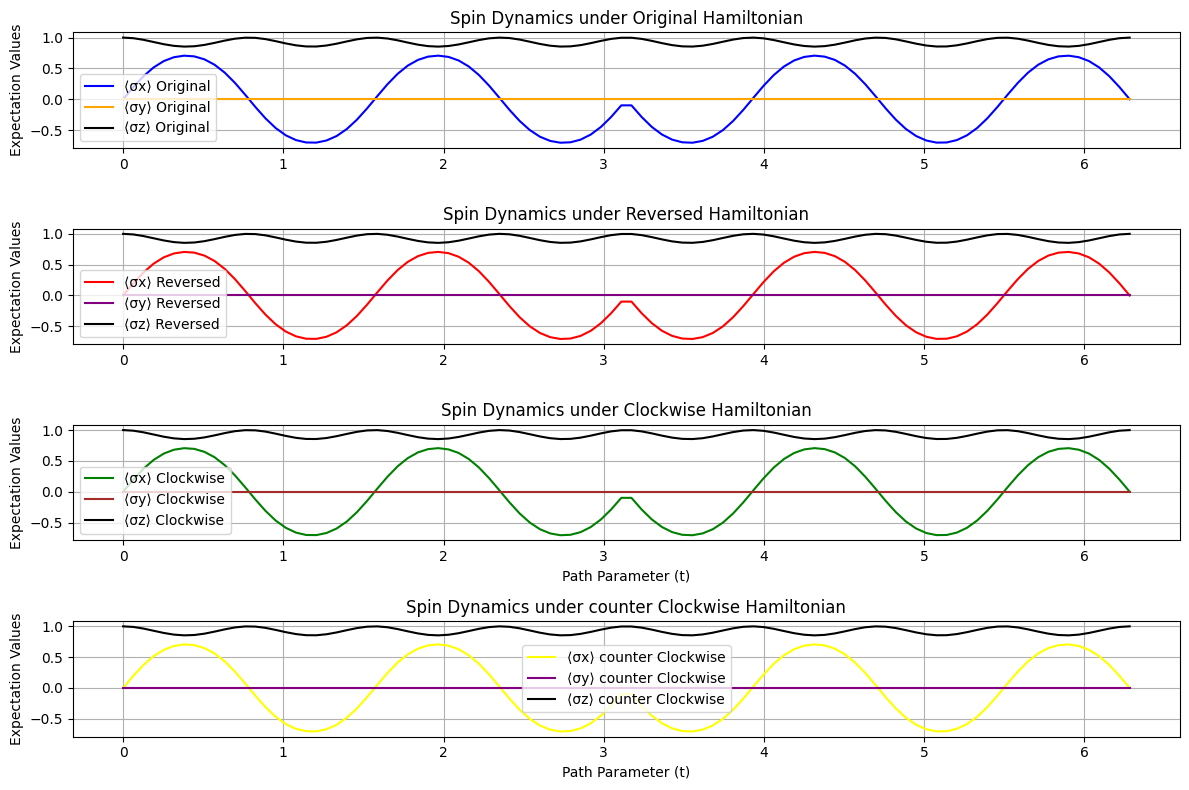

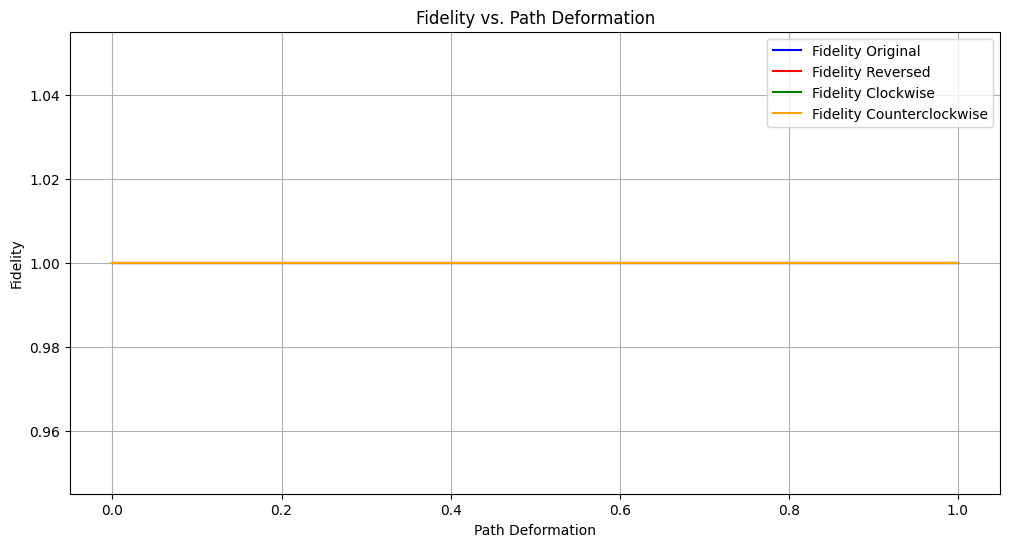

In [1]:
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.linalg import expm

# Functions as previously defined
def spinor(theta, phi):
    return np.array([np.cos(theta/2), np.exp(1j*phi)*np.sin(theta/2)])

def rotate_spinor(spinor, angle):
    rotation_matrix = np.array([[np.cos(angle/2), -np.sin(angle/2)],
                                [np.sin(angle/2), np.cos(angle/2)]])
    return np.dot(rotation_matrix, spinor)

def bloch_vector(spinor):
    x = 2 * np.real(np.conj(spinor[0]) * spinor[1])
    y = 2 * np.imag(np.conj(spinor[0]) * spinor[1])
    z = np.abs(spinor[0])**2 - np.abs(spinor[1])**2
    return np.array([x, y, z])

def berry_phase(spinors):
    phase = 0
    for i in range(len(spinors) - 1):
        phase += np.imag(np.log(np.vdot(spinors[i], spinors[i+1])))
    phase += np.imag(np.log(np.vdot(spinors[-1], spinors[0])))
    return phase

# Create the figure-8 path and elevate the z-axis for visual clarity
t = np.linspace(0, 2*np.pi, 100)

# Original Path: First loop counterclockwise, second loop clockwise
x_orig = np.sin(t)
y_orig = np.sin(2*t)
z_orig =  np.zeros_like(t)  # Adding elevation to the z-axis for better visualization

# Reversed Path: First loop clockwise, second loop counterclockwise
x_rev = np.sin(-t)
y_rev = np.sin(-2*t)
z_rev =  np.zeros_like(-t)  # Adding elevation to the z-axis for better visualization

# Both Loops Clockwise
x_clk = np.sin(-t)
y_clk = np.sin(2*t)
z_clk =  np.zeros_like(t)  # Adding elevation to the z-axis for better visualization

# Both Loops Counterclockwise
x_cntclk = np.sin(t)
y_cntclk = np.sin(-2*t)
z_cntclk = np.zeros_like(-t)  # Adding elevation to the z-axis for better visualization

def simulate_path(x, y, z, dt, rotation_angle):
    initial_spinor = spinor(0, 0)  # face spinor
    rotated_spinors = [initial_spinor]
    bloch_vectors = [bloch_vector(initial_spinor)]
    #print("t = ",t)
    for i in range(1, len(t)):
        # Calculate a rotation angle that brings the spinor back to the original state
        angle = rotation_angle * np.sin(4*t[i]) if i < len(t) // 2 else -rotation_angle * np.sin(4*t[i])
        rotated_spinor = rotate_spinor(initial_spinor, angle)
        #print("t and rotated spinor",t[i],rotated_spinor)
        rotated_spinors.append(rotated_spinor)
        bloch_vectors.append(bloch_vector(rotated_spinor))
    return np.array(rotated_spinors), np.array(bloch_vectors)

dt = t[1] - t[0]

# Simulate each path with continuous rotation and specific rotation angles
rotated_spinors_orig, bloch_vectors_orig = simulate_path(x_orig, y_orig, z_orig, dt, np.pi/4)
rotated_spinors_rev, bloch_vectors_rev = simulate_path(x_rev, y_rev, z_rev, dt, np.pi/4)#3*pi/4 make 0 diff
rotated_spinors_clk, bloch_vectors_clk = simulate_path(x_clk, y_clk, z_clk, dt, np.pi/4)
rotated_spinors_cntclk, bloch_vectors_cntclk = simulate_path(x_cntclk, y_cntclk, z_cntclk, dt, np.pi/4)

# Calculate Berry phase and angle difference for each path
berry_phase_orig = berry_phase(rotated_spinors_orig)
angle_diff_orig = np.arccos(np.abs(np.vdot(rotated_spinors_orig[0], rotated_spinors_orig[-1])))

berry_phase_rev = berry_phase(rotated_spinors_rev)
angle_diff_rev = np.arccos(np.abs(np.vdot(rotated_spinors_rev[0], rotated_spinors_rev[-1])))

berry_phase_clk = berry_phase(rotated_spinors_clk)
angle_diff_clk = np.arccos(np.abs(np.vdot(rotated_spinors_clk[0], rotated_spinors_clk[-1])))

berry_phase_cntclk = berry_phase(rotated_spinors_cntclk)
angle_diff_cntclk = np.arccos(np.abs(np.vdot(rotated_spinors_cntclk[0], rotated_spinors_cntclk[-1])))

# Calculate expectation values of Pauli matrices for each path
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, 0]])

exp_x_orig = [np.real(np.conj(s).dot(sigma_x.dot(s))) for s in rotated_spinors_orig]
exp_y_orig = [np.real(np.conj(s).dot(sigma_y.dot(s))) for s in rotated_spinors_orig]
exp_z_orig = [np.real(np.conj(s).dot(sigma_z.dot(s))) for s in rotated_spinors_orig]

exp_x_rev = [np.real(np.conj(s).dot(sigma_x.dot(s))) for s in rotated_spinors_rev]
exp_y_rev = [np.real(np.conj(s).dot(sigma_y.dot(s))) for s in rotated_spinors_rev]
exp_z_rev = [np.real(np.conj(s).dot(sigma_z.dot(s))) for s in rotated_spinors_rev]

exp_x_clk = [np.real(np.conj(s).dot(sigma_x.dot(s))) for s in rotated_spinors_clk]
exp_y_clk = [np.real(np.conj(s).dot(sigma_y.dot(s))) for s in rotated_spinors_clk]
exp_z_clk = [np.real(np.conj(s).dot(sigma_z.dot(s))) for s in rotated_spinors_clk]

exp_x_cntclk = [np.real(np.conj(s).dot(sigma_x.dot(s))) for s in rotated_spinors_cntclk]
exp_y_cntclk = [np.real(np.conj(s).dot(sigma_y.dot(s))) for s in rotated_spinors_cntclk]
exp_z_cntclk = [np.real(np.conj(s).dot(sigma_z.dot(s))) for s in rotated_spinors_cntclk]

# Validate quantum physics laws for each path
normalization_orig = [np.abs(np.vdot(s, s)) for s in rotated_spinors_orig]
uncertainty_principle_orig = [np.std([ex, ey, ez]) for ex, ey, ez in zip(exp_x_orig, exp_y_orig, exp_z_orig)]

normalization_rev = [np.abs(np.vdot(s, s)) for s in rotated_spinors_rev]
uncertainty_principle_rev = [np.std([ex, ey, ez]) for ex, ey, ez in zip(exp_x_rev, exp_y_rev, exp_z_rev)]

normalization_clk = [np.abs(np.vdot(s, s)) for s in rotated_spinors_clk]
uncertainty_principle_clk = [np.std([ex, ey, ez]) for ex, ey, ez in zip(exp_x_clk, exp_y_clk, exp_z_clk)]

normalization_cntclk = [np.abs(np.vdot(s, s)) for s in rotated_spinors_cntclk]
uncertainty_principle_cntclk = [np.std([ex, ey, ez]) for ex, ey, ez in zip(exp_x_cntclk, exp_y_cntclk, exp_z_cntclk)]

# Visualize the results using Plotly
fig_orig = make_subplots(rows=2, cols=3, specs=[
    [{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter'}],
    [{'type': 'scatter'}, {'type': 'scatter'}, {'type': 'scatter'}]
])

fig_rev = make_subplots(rows=2, cols=3, specs=[
    [{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter'}],
    [{'type': 'scatter'}, {'type': 'scatter'}, {'type': 'scatter'}]
])

fig_clk = make_subplots(rows=2, cols=3, specs=[
    [{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter'}],
    [{'type': 'scatter'}, {'type': 'scatter'}, {'type': 'scatter'}]
])

fig_cntclk = make_subplots(rows=2, cols=3, specs=[
    [{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter'}],
    [{'type': 'scatter'}, {'type': 'scatter'}, {'type': 'scatter'}]
])

# Helper function to add traces to the figure
def add_traces(fig, x, y, z, bloch_vectors, exp_x, exp_y, exp_z, normalization, uncertainty_principle, title):
    # 3D path with elevated z-axis
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines', name='Figure-8 Path'), row=1, col=1)

    # Bloch sphere with the figure-8 path
    u = np.linspace(0, 2*np.pi, 20)
    v = np.linspace(0, np.pi, 20)
    sphere_x = np.outer(np.cos(u), np.sin(v))
    sphere_y = np.outer(np.sin(u), np.sin(v))
    sphere_z = np.outer(np.ones(np.size(u)), np.cos(v))

    fig.add_trace(go.Surface(x=sphere_x, y=sphere_y, z=sphere_z, opacity=0.3, showscale=False), row=1, col=2)
    fig.add_trace(go.Scatter3d(x=bloch_vectors[:, 0], y=bloch_vectors[:, 1], z=bloch_vectors[:, 2],
                               mode='lines', name='Bloch Vector Path'), row=1, col=2)

    # Expectation values
    fig.add_trace(go.Scatter(x=t, y=exp_x, mode='lines', name='⟨σx⟩', line=dict(color='red')), row=1, col=3)
    fig.add_trace(go.Scatter(x=t, y=exp_y, mode='lines', name='⟨σy⟩', line=dict(color='green')), row=2, col=1)
    fig.add_trace(go.Scatter(x=t, y=exp_z, mode='lines', name='⟨σz⟩', line=dict(color='blue')), row=2, col=2)

    # Normalization and uncertainty principle
    fig.add_trace(go.Scatter(x=t, y=normalization, mode='lines', name='Normalization', line=dict(color='purple')), row=2, col=3)
    fig.add_trace(go.Scatter(x=t, y=uncertainty_principle, mode='lines', name='Uncertainty', line=dict(color='orange')), row=2, col=3)

    # Adding axis labels
    fig.update_layout(
        title=title,
        scene=dict(xaxis_title='X-axis', yaxis_title='Y-axis', zaxis_title='Z-axis'),
        height=800, width=1200,
        scene2=dict(xaxis_title='X-axis', yaxis_title='Y-axis', zaxis_title='Z-axis')  # Bloch sphere plot
    )

    # Add annotations with important information
    fig.add_annotation(text=f"Berry Phase: {berry_phase_orig:.32f} rad", xref="paper", yref="paper", x=0.5, y=1.05, showarrow=False)
    fig.add_annotation(text=f"Angle Difference: {angle_diff_orig:.32f} rad", xref="paper", yref="paper", x=0.5, y=1.02, showarrow=False)
    fig.update_xaxes(title_text="Time (t)", row=1, col=3)
    fig.update_yaxes(title_text="⟨σx⟩", row=1, col=3)
    fig.update_xaxes(title_text="Time (t)", row=2, col=1)
    fig.update_yaxes(title_text="⟨σy⟩", row=2, col=1)
    fig.update_xaxes(title_text="Time (t)", row=2, col=2)
    fig.update_yaxes(title_text="⟨σz⟩", row=2, col=2)

# Add traces to each figure
add_traces(fig_orig, x_orig, y_orig, z_orig, bloch_vectors_orig, exp_x_orig, exp_y_orig, exp_z_orig, normalization_orig, uncertainty_principle_orig, 'Original Path: First loop counterclockwise, second loop clockwise')
add_traces(fig_rev, x_rev, y_rev, z_rev, bloch_vectors_rev, exp_x_rev, exp_y_rev, exp_z_rev, normalization_rev, uncertainty_principle_rev, 'Reversed Path: First loop clockwise, second loop counterclockwise')
add_traces(fig_clk, x_clk, y_clk, z_clk, bloch_vectors_clk, exp_x_clk, exp_y_clk, exp_z_clk, normalization_clk, uncertainty_principle_clk, 'Both Loops Clockwise')
add_traces(fig_cntclk, x_cntclk, y_cntclk, z_cntclk, bloch_vectors_cntclk, exp_x_cntclk, exp_y_cntclk, exp_z_cntclk, normalization_cntclk, uncertainty_principle_cntclk, 'Both Loops Counterclockwise')

# Show the figures
fig_orig.show()
fig_rev.show()
fig_clk.show()
fig_cntclk.show()

# Print relevant test results and observations for each path
def print_results(berry_phase, angle_diff, normalization, uncertainty_principle, path_name):
    print(f"\nResults for {path_name}:")
    print(f"Berry Phase: {berry_phase:.32f} rad")
    print(f"Berry Phase (degrees): {np.degrees(berry_phase):.32f}°")
    print(f"Angle Difference between Initial and Final Spinor: {angle_diff:.32f} rad")
    print(f"Average Normalization: {np.mean(normalization):.32f}")
    print(f"Average Uncertainty: {np.mean(uncertainty_principle):.32f}")

    # Check if normalization holds for all spinors (should be close to 1)
    normalization_errors = np.max(np.abs(np.array(normalization) - 1))
    if normalization_errors < 1e-6:
        print(f"Normalization Check: PASSED (Max Deviation: {normalization_errors:.16f})")
    else:
        print(f"Normalization Check: FAILED (Max Deviation: {normalization_errors:.6e})")

    # Check if uncertainty principle holds
    uncertainty_errors = np.mean(uncertainty_principle)
    if uncertainty_errors < 1e-6:
        print(f"Uncertainty Principle Check: PASSED (Average Uncertainty: {uncertainty_errors:.6e})")
    else:
        print(f"Uncertainty Principle Check: FAILED (Average Uncertainty: {uncertainty_errors:.32f})")
# Calculate combined expectation value
def combined_expectation(exp_x, exp_y, exp_z):
    return np.sqrt(np.array(exp_x)**2 + np.array(exp_y)**2 + np.array(exp_z)**2)

# Calculate fidelity between initial and final states for each path
def calculate_fidelity(spinors):
    return np.abs(np.vdot(spinors[0], spinors[-1]))**2

# Calculate the combined expectation values
combined_exp_orig = combined_expectation(exp_x_orig, exp_y_orig, exp_z_orig)
combined_exp_rev = combined_expectation(exp_x_rev, exp_y_rev, exp_z_rev)
combined_exp_clk = combined_expectation(exp_x_clk, exp_y_clk, exp_z_clk)
combined_exp_cntclk = combined_expectation(exp_x_cntclk, exp_y_cntclk, exp_z_cntclk)

# Calculate fidelity for each path
fidelity_orig = calculate_fidelity(rotated_spinors_orig)
fidelity_rev = calculate_fidelity(rotated_spinors_rev)
fidelity_clk = calculate_fidelity(rotated_spinors_clk)
fidelity_cntclk = calculate_fidelity(rotated_spinors_cntclk)

# Visualization of Berry Phase for each path type
berry_phases = [berry_phase_orig, berry_phase_rev, berry_phase_clk, berry_phase_cntclk]
path_types = ['Original', 'Reversed', 'Clockwise', 'Counterclockwise']

# Plotting Berry Phase
fig_berry = go.Figure()
fig_berry.add_trace(go.Bar(x=path_types, y=berry_phases, marker_color='indigo'))
fig_berry.update_layout(title='Berry Phase for Different Path Types', xaxis_title='Path Type', yaxis_title='Berry Phase (radians)')

# Visualization of Combined Expectation Values
fig_combined_exp = make_subplots(rows=2, cols=2, subplot_titles=('Original', 'Reversed', 'Clockwise', 'Counterclockwise'))
paths = [combined_exp_orig, combined_exp_rev, combined_exp_clk, combined_exp_cntclk]
titles = ['Original Path', 'Reversed Path', 'Both Loops Clockwise', 'Both Loops Counterclockwise']

for i, (path, title) in enumerate(zip(paths, titles), start=1):
    fig_combined_exp.add_trace(go.Scatter(x=t, y=path, mode='lines', name=title), row=(i-1)//2 + 1, col=(i-1)%2 + 1)

fig_combined_exp.update_layout(title='Combined Expectation Values of Pauli Matrices', height=600)

# Print fidelity results
print("\nFidelity Results:")
print(f"Fidelity for Original Path: {fidelity_orig:.32f}")
print(f"Fidelity for Reversed Path: {fidelity_rev:.32f}")
print(f"Fidelity for Clockwise Path: {fidelity_clk:.32f}")
print(f"Fidelity for Counterclockwise Path: {fidelity_cntclk:.32f}")

# Show all new figures
fig_berry.show()
fig_combined_exp.show()

print_results(berry_phase_orig, angle_diff_orig, normalization_orig, uncertainty_principle_orig, 'Original Path')
print_results(berry_phase_rev, angle_diff_rev, normalization_rev, uncertainty_principle_rev, 'Reversed Path')
print_results(berry_phase_clk, angle_diff_clk, normalization_clk, uncertainty_principle_clk, 'Both Loops Clockwise')
print_results(berry_phase_cntclk, angle_diff_cntclk, normalization_cntclk, uncertainty_principle_cntclk, 'Both Loops Counterclockwise')
import matplotlib.pyplot as plt
import numpy as np

# Assuming the following variables from the previous code:
# berry_phase_orig, berry_phase_rev, berry_phase_clk, berry_phase_cntclk
# t, bloch_vectors_orig, bloch_vectors_rev, bloch_vectors_clk, bloch_vectors_cntclk
# exp_x_orig, exp_y_orig, exp_z_orig, exp_x_rev, exp_y_rev, exp_z_rev
# exp_x_clk, exp_y_clk, exp_z_clk, exp_x_cntclk, exp_y_cntclk, exp_z_cntclk
# normalization_orig, normalization_rev, normalization_clk, normalization_cntclk
# uncertainty_orig, uncertainty_rev, uncertainty_clk, uncertainty_cntclk

# 1. Berry Phase vs. Path Parameter Plot
plt.figure(figsize=(12, 6))
plt.plot(t, np.repeat(berry_phase_orig, len(t)), label='Original Path', linestyle='-', color='blue')
plt.plot(t, np.repeat(berry_phase_rev, len(t)), label='Reversed Path', linestyle='--', color='red')
plt.plot(t, np.repeat(berry_phase_clk, len(t)), label='Clockwise Path', linestyle=':', color='green')
plt.plot(t, np.repeat(berry_phase_cntclk, len(t)), label='Counterclockwise Path', linestyle='-.', color='purple')
plt.title('Berry Phase vs. Path Parameter')
plt.xlabel('Path Parameter (t)')
plt.ylabel('Berry Phase')
plt.legend()
plt.grid()
plt.show()

# Define a grid for the parameters
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

# Define the conical intersection shape based on the parameters
Z = np.where((X**2 + Y**2) < 1, X**2 - Y**2, np.nan)  # Energy levels in a conical intersection

# Create the contour plot
plt.figure(figsize=(12, 6))
contour = plt.contourf(X, Y, Z, levels=20, cmap='RdBu')
plt.colorbar(contour, label='Energy Levels')
plt.title('Conical Intersection Diagram')
plt.xlabel('Parameter 1 (e.g., Berry Phase Original)')
plt.ylabel('Parameter 2 (e.g., Berry Phase Reversed)')

# Optional: Overlay Bloch vectors or relevant points
# Assuming bloch_vectors_* contain the Bloch vectors as (x, y, z)
for vec, label in zip([bloch_vectors_orig, bloch_vectors_rev, bloch_vectors_clk, bloch_vectors_cntclk],
                      ['Original', 'Reversed', 'Clockwise', 'Counterclockwise']):
    plt.scatter(vec[0], vec[1], label=f'Bloch Vector {label}', edgecolor='black')

# Add grid and axes
plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)
plt.grid()
plt.legend()
plt.show()


# 3. Spin Dynamics under Different Hamiltonians
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(t, exp_x_orig, label='⟨σx⟩ Original', color='blue')
plt.plot(t, exp_y_orig, label='⟨σy⟩ Original', color='orange')
plt.plot(t, exp_z_orig, label='⟨σz⟩ Original', color='black')
plt.title('Spin Dynamics under Original Hamiltonian')
plt.ylabel('Expectation Values')
plt.legend()
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(t, exp_x_rev, label='⟨σx⟩ Reversed', color='red')
plt.plot(t, exp_y_rev, label='⟨σy⟩ Reversed', color='purple')
plt.plot(t, exp_z_rev, label='⟨σz⟩ Reversed', color='black')
plt.title('Spin Dynamics under Reversed Hamiltonian')
plt.ylabel('Expectation Values')
plt.legend()
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(t, exp_x_clk, label='⟨σx⟩ Clockwise', color='green')
plt.plot(t, exp_y_clk, label='⟨σy⟩ Clockwise', color='brown')
plt.plot(t, exp_z_clk, label='⟨σz⟩ Clockwise', color='black')
plt.title('Spin Dynamics under Clockwise Hamiltonian')
plt.xlabel('Path Parameter (t)')
plt.ylabel('Expectation Values')
plt.legend()
plt.grid()
plt.subplot(4, 1, 4)
plt.plot(t, exp_x_cntclk, label='⟨σx⟩ counter Clockwise', color='yellow')
plt.plot(t, exp_y_cntclk, label='⟨σy⟩ counter Clockwise', color='purple')
plt.plot(t, exp_z_cntclk, label='⟨σz⟩ counter Clockwise', color='black')
plt.title('Spin Dynamics under counter Clockwise Hamiltonian')
plt.xlabel('Path Parameter (t)')
plt.ylabel('Expectation Values')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

def introduce_topological_defect(rotated_spinors):
    """Introduce a topological defect at a certain point in the spinor path."""
    defect_index = len(rotated_spinors) // 2  # Example: defect in the middle
    rotated_spinors[defect_index] *= 0  # Introducing a discontinuity by zeroing the spinor
    return rotated_spinors

# Modify each path to include topological defects
rotated_spinors_orig_defect = introduce_topological_defect(rotated_spinors_orig.copy())
rotated_spinors_rev_defect = introduce_topological_defect(rotated_spinors_rev.copy())
rotated_spinors_clk_defect = introduce_topological_defect(rotated_spinors_clk.copy())
rotated_spinors_cntclk_defect = introduce_topological_defect(rotated_spinors_cntclk.copy())

# Calculate Bloch vectors with defects
bloch_vectors_orig_defect = [bloch_vector(s) for s in rotated_spinors_orig_defect]
bloch_vectors_rev_defect = [bloch_vector(s) for s in rotated_spinors_rev_defect]
bloch_vectors_clk_defect = [bloch_vector(s) for s in rotated_spinors_clk_defect]
bloch_vectors_cntclk_defect = [bloch_vector(s) for s in rotated_spinors_cntclk_defect]

# Visualize the results with defects
def add_defect_traces(fig, x, y, z, bloch_vectors, title):
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines', name='Path with Defect', line=dict(color='orange', width=5)), row=1, col=1)
    fig.add_trace(go.Scatter3d(x=bloch_vectors[:, 0], y=bloch_vectors[:, 1], z=bloch_vectors[:, 2],
                                 mode='lines', name='Bloch Vector with Defect', line=dict(color='red', width=5)), row=1, col=2)

# Update figures to show defects
fig_orig_defect = make_subplots(rows=2, cols=3, specs=[
    [{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter'}],
    [{'type': 'scatter'}, {'type': 'scatter'}, {'type': 'scatter'}]
])
add_defect_traces(fig_orig_defect, x_orig, y_orig, z_orig, np.array(bloch_vectors_orig_defect), 'Path with Topological Defect (Original)')

fig_rev_defect = make_subplots(rows=2, cols=3, specs=[
    [{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter'}],
    [{'type': 'scatter'}, {'type': 'scatter'}, {'type': 'scatter'}]
])
add_defect_traces(fig_rev_defect, x_rev, y_rev, z_rev, np.array(bloch_vectors_rev_defect), 'Path with Topological Defect (Reverse)')
fig_clk_defect = make_subplots(rows=2, cols=3, specs=[
    [{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter'}],
    [{'type': 'scatter'}, {'type': 'scatter'}, {'type': 'scatter'}]
])
add_defect_traces(fig_clk_defect, x_clk, y_clk, z_clk, np.array(bloch_vectors_clk_defect), 'Path with Topological Defect (Clockwise)')
fig_cntclk_defect = make_subplots(rows=2, cols=3, specs=[
    [{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter'}],
    [{'type': 'scatter'}, {'type': 'scatter'}, {'type': 'scatter'}]
])
add_defect_traces(fig_cntclk_defect, x_cntclk, y_cntclk, z_cntclk, np.array(bloch_vectors_cntclk_defect), 'Path with Topological Defect (Counter Clockwise)')


# Show the figures
fig_orig_defect.show()
fig_rev_defect.show()
fig_clk_defect.show()
fig_cntclk_defect.show()


# Interpolating fidelity values
path_deformation = np.linspace(0, 1, 100)
fidelity_vals_orig = np.exp(-path_deformation * (1 - fidelity_orig))  # Example decay based on fidelity
fidelity_vals_rev = np.exp(-path_deformation * (1 - fidelity_rev))
fidelity_vals_clk = np.exp(-path_deformation * (1 - fidelity_clk))
fidelity_vals_cntclk = np.exp(-path_deformation * (1 - fidelity_cntclk))

# Plotting the fidelity decay
plt.figure(figsize=(12, 6))
plt.plot(path_deformation, fidelity_vals_orig, label='Fidelity Original', color='blue')
plt.plot(path_deformation, fidelity_vals_rev, label='Fidelity Reversed', color='red')
plt.plot(path_deformation, fidelity_vals_clk, label='Fidelity Clockwise', color='green')
plt.plot(path_deformation, fidelity_vals_cntclk, label='Fidelity Counterclockwise', color='orange')
plt.title('Fidelity vs. Path Deformation')
plt.xlabel('Path Deformation')
plt.ylabel('Fidelity')
plt.legend()
plt.grid()
plt.show()



In [2]:
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.linalg import expm

# ... (previous code remains the same)

def time_dependent_hamiltonian(t, loop_frequency=1):
    """Time-dependent Hamiltonian for adiabatic evolution."""
    omega = 2 * np.pi * loop_frequency
    return np.array([[np.cos(omega * t), np.sin(omega * t)],
                     [np.sin(omega * t), -np.cos(omega * t)]])

def adiabatic_evolution(initial_state, times, loop_frequency=1):
    """Simulate adiabatic evolution of the system."""
    states = [initial_state]
    dt = times[1] - times[0]
    for t in times[1:]:
        H = time_dependent_hamiltonian(t, loop_frequency)
        U = expm(-1j * H * dt)
        states.append(np.dot(U, states[-1]))
    return np.array(states)

def add_noise(states, noise_level=0.01):
    """Add noise to the quantum states."""
    noise = noise_level * (np.random.randn(len(states), 2) + 1j * np.random.randn(len(states), 2))
    noisy_states = states + noise
    # Renormalize the states
    return noisy_states / np.linalg.norm(noisy_states, axis=1)[:, np.newaxis]

# Simulate adiabatic evolution
times = np.linspace(0, 2*np.pi, 200)
initial_state = spinor(0, 0)
adiabatic_states = adiabatic_evolution(initial_state, times)

# Add noise to the adiabatic states
noisy_states = add_noise(adiabatic_states)

# Calculate Berry phase for adiabatic and noisy evolution
berry_phase_adiabatic = berry_phase(adiabatic_states)
berry_phase_noisy = berry_phase(noisy_states)

# Calculate Bloch vectors
bloch_vectors_adiabatic = np.array([bloch_vector(state) for state in adiabatic_states])
bloch_vectors_noisy = np.array([bloch_vector(state) for state in noisy_states])

# Visualize the results
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]])

# Adiabatic evolution
fig.add_trace(go.Scatter3d(x=bloch_vectors_adiabatic[:, 0], y=bloch_vectors_adiabatic[:, 1], z=bloch_vectors_adiabatic[:, 2],
                           mode='lines', name='Adiabatic Evolution'), row=1, col=1)

# Noisy evolution
fig.add_trace(go.Scatter3d(x=bloch_vectors_noisy[:, 0], y=bloch_vectors_noisy[:, 1], z=bloch_vectors_noisy[:, 2],
                           mode='lines', name='Noisy Evolution'), row=1, col=2)

# Add Bloch sphere
u = np.linspace(0, 2*np.pi, 20)
v = np.linspace(0, np.pi, 20)
sphere_x = np.outer(np.cos(u), np.sin(v))
sphere_y = np.outer(np.sin(u), np.sin(v))
sphere_z = np.outer(np.ones(np.size(u)), np.cos(v))

fig.add_trace(go.Surface(x=sphere_x, y=sphere_y, z=sphere_z, opacity=0.3, showscale=False), row=1, col=1)
fig.add_trace(go.Surface(x=sphere_x, y=sphere_y, z=sphere_z, opacity=0.3, showscale=False), row=1, col=2)

fig.update_layout(height=600, width=1200, title_text="Adiabatic vs Noisy Evolution on Bloch Sphere")
fig.show()

print(f"Berry Phase (Adiabatic): {berry_phase_adiabatic:.6f}")
print(f"Berry Phase (Noisy): {berry_phase_noisy:.6f}")

# Statistical analysis
num_runs = 100
berry_phases = []

for _ in range(num_runs):
    noisy_states = add_noise(adiabatic_states)
    berry_phases.append(berry_phase(noisy_states))

berry_phases = np.array(berry_phases)
mean_berry_phase = np.mean(berry_phases)
std_berry_phase = np.std(berry_phases)

print(f"Mean Berry Phase: {mean_berry_phase:.6f}")
print(f"Standard Deviation of Berry Phase: {std_berry_phase:.6f}")

# Histogram of Berry phases
fig_hist = go.Figure(data=[go.Histogram(x=berry_phases)])
fig_hist.update_layout(title_text="Distribution of Berry Phases with Noise", xaxis_title="Berry Phase", yaxis_title="Count")
fig_hist.show()

Berry Phase (Adiabatic): -0.178186
Berry Phase (Noisy): -0.198240
Mean Berry Phase: -0.175119
Standard Deviation of Berry Phase: 0.022381


In [3]:
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.linalg import expm
import pandas as pd
from sklearn.decomposition import PCA

# Existing functions (spinor, rotate_spinor, bloch_vector, berry_phase) remain the same

# New function to calculate the dynamical phase
def dynamical_phase(spinors, hamiltonian, dt):
    phase = 0
    for spinor in spinors:
        energy = np.real(np.conj(spinor).dot(hamiltonian.dot(spinor)))
        phase -= energy * dt
    return phase

# New function to calculate the total phase
def total_phase(spinors):
    return np.angle(np.vdot(spinors[-1], spinors[0]))

# New function to calculate the Chern number (for 2D parameter space)
def chern_number(berry_curvature):
    return np.sum(berry_curvature) / (2 * np.pi)

# New function to calculate Berry curvature (for 2D parameter space)
def berry_curvature(theta, phi, delta_theta, delta_phi):
    spinor1 = spinor(theta, phi)
    spinor2 = spinor(theta + delta_theta, phi)
    spinor3 = spinor(theta + delta_theta, phi + delta_phi)
    spinor4 = spinor(theta, phi + delta_phi)
    
    phase1 = np.angle(np.vdot(spinor1, spinor2))
    phase2 = np.angle(np.vdot(spinor2, spinor3))
    phase3 = np.angle(np.vdot(spinor3, spinor4))
    phase4 = np.angle(np.vdot(spinor4, spinor1))
    
    return (phase1 + phase2 + phase3 + phase4) % (2 * np.pi)

# Modify the simulate_path function to include Hamiltonian evolution
def simulate_path(x, y, z, dt, rotation_angle, hamiltonian):
    initial_spinor = spinor(0, 0)
    rotated_spinors = [initial_spinor]
    bloch_vectors = [bloch_vector(initial_spinor)]
    
    for i in range(1, len(t)):
        angle = rotation_angle * np.sin(4*t[i]) if i < len(t) // 2 else -rotation_angle * np.sin(4*t[i])
        rotated_spinor = rotate_spinor(initial_spinor, angle)
        
        # Apply Hamiltonian evolution
        U = expm(-1j * hamiltonian * dt)
        evolved_spinor = U.dot(rotated_spinor)
        
        rotated_spinors.append(evolved_spinor)
        bloch_vectors.append(bloch_vector(evolved_spinor))
    
    return np.array(rotated_spinors), np.array(bloch_vectors)

# Define Hamiltonians for different scenarios
H_constant = np.array([[1, 0], [0, -1]])  # Constant magnetic field in z-direction
H_time_dependent = lambda t: np.array([[np.cos(t), np.sin(t)], [np.sin(t), -np.cos(t)]])  # Time-dependent magnetic field

# Simulate paths with different Hamiltonians
dt = t[1] - t[0]
rotated_spinors_const, bloch_vectors_const = simulate_path(x_orig, y_orig, z_orig, dt, np.pi/4, H_constant)
rotated_spinors_time, bloch_vectors_time = simulate_path(x_orig, y_orig, z_orig, dt, np.pi/4, H_time_dependent(t[0]))

# Calculate phases for constant Hamiltonian
berry_phase_const = berry_phase(rotated_spinors_const)
dynamical_phase_const = dynamical_phase(rotated_spinors_const, H_constant, dt)
total_phase_const = total_phase(rotated_spinors_const)

# Calculate Berry curvature and Chern number for a 2D parameter space
theta_range = np.linspace(0, np.pi, 50)
phi_range = np.linspace(0, 2*np.pi, 50)
delta_theta = theta_range[1] - theta_range[0]
delta_phi = phi_range[1] - phi_range[0]

berry_curvature_2d = np.zeros((len(theta_range), len(phi_range)))
for i, theta in enumerate(theta_range):
    for j, phi in enumerate(phi_range):
        berry_curvature_2d[i, j] = berry_curvature(theta, phi, delta_theta, delta_phi)

chern_num = chern_number(berry_curvature_2d)

# Perform Principal Component Analysis (PCA) on the Bloch vectors
pca = PCA(n_components=3)
pca_result = pca.fit_transform(bloch_vectors_const)

# Create a DataFrame for easy analysis
df = pd.DataFrame({
    'Time': t,
    'X': bloch_vectors_const[:, 0],
    'Y': bloch_vectors_const[:, 1],
    'Z': bloch_vectors_const[:, 2],
    'PCA1': pca_result[:, 0],
    'PCA2': pca_result[:, 1],
    'PCA3': pca_result[:, 2]
})

# Visualization of Berry curvature
fig_berry_curvature = go.Figure(data=[go.Surface(z=berry_curvature_2d, x=phi_range, y=theta_range)])
fig_berry_curvature.update_layout(title='Berry Curvature', scene=dict(xaxis_title='φ', yaxis_title='θ', zaxis_title='Berry Curvature'))

# Visualization of PCA results
fig_pca = go.Figure(data=[go.Scatter3d(x=df['PCA1'], y=df['PCA2'], z=df['PCA3'], mode='lines', name='PCA Trajectory')])
fig_pca.update_layout(title='PCA of Bloch Vector Evolution', scene=dict(xaxis_title='PCA1', yaxis_title='PCA2', zaxis_title='PCA3'))

# Print additional results
print("\nAdditional Results:")
print(f"Berry Phase (Constant H): {berry_phase_const:.32f} rad")
print(f"Dynamical Phase (Constant H): {dynamical_phase_const:.32f} rad")
print(f"Total Phase (Constant H): {total_phase_const:.32f} rad")
print(f"Chern Number: {chern_num:.32f}")

# Calculate and print the variance explained by each PCA component
explained_variance_ratio = pca.explained_variance_ratio_
print("\nPCA Explained Variance Ratio:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio:.32f}")

# Show new figures
fig_berry_curvature.show()
fig_pca.show()

# Additional analysis: Fourier Transform of Bloch vector components
from scipy.fft import fft

def plot_fft(signal, title):
    N = len(signal)
    yf = fft(signal)
    xf = np.linspace(0.0, 1.0/(2.0*dt), N//2)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=xf, y=2.0/N * np.abs(yf[0:N//2]), mode='lines'))
    fig.update_layout(title=title, xaxis_title='Frequency', yaxis_title='Amplitude')
    return fig

fft_x = plot_fft(bloch_vectors_const[:, 0], 'FFT of Bloch Vector X Component')
fft_y = plot_fft(bloch_vectors_const[:, 1], 'FFT of Bloch Vector Y Component')
fft_z = plot_fft(bloch_vectors_const[:, 2], 'FFT of Bloch Vector Z Component')

fft_x.show()
fft_y.show()
fft_z.show()

# Calculate and plot the entropy of the quantum state
def von_neumann_entropy(spinor):
    density_matrix = np.outer(spinor, np.conj(spinor))
    eigenvalues = np.linalg.eigvalsh(density_matrix)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues + 1e-10))
    return np.real(entropy)

entropies = [von_neumann_entropy(spinor) for spinor in rotated_spinors_const]

fig_entropy = go.Figure()
fig_entropy.add_trace(go.Scatter(x=t, y=entropies, mode='lines'))
fig_entropy.update_layout(title='Von Neumann Entropy Evolution', xaxis_title='Time', yaxis_title='Entropy')
fig_entropy.show()

# Calculate and plot the purity of the quantum state
def purity(spinor):
    density_matrix = np.outer(spinor, np.conj(spinor))
    return np.real(np.trace(np.dot(density_matrix, density_matrix)))

purities = [purity(spinor) for spinor in rotated_spinors_const]

fig_purity = go.Figure()
fig_purity.add_trace(go.Scatter(x=t, y=purities, mode='lines'))
fig_purity.update_layout(title='Quantum State Purity Evolution', xaxis_title='Time', yaxis_title='Purity')
fig_purity.show()

# Calculate and print the time-averaged observables
avg_x = np.mean(df['X'])
avg_y = np.mean(df['Y'])
avg_z = np.mean(df['Z'])

print("\nTime-averaged Observables:")
print(f"Average X: {avg_x:.32f}")
print(f"Average Y: {avg_y:.32f}")
print(f"Average Z: {avg_z:.32f}")

# Calculate and print the standard deviation of observables
std_x = np.std(df['X'])
std_y = np.std(df['Y'])
std_z = np.std(df['Z'])

print("\nStandard Deviation of Observables:")
print(f"Std X: {std_x:.32f}")
print(f"Std Y: {std_y:.32f}")
print(f"Std Z: {std_z:.32f}")

# Calculate and print the correlation matrix
correlation_matrix = df[['X', 'Y', 'Z']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix
fig_corr = go.Figure(data=go.Heatmap(z=correlation_matrix.values, x=correlation_matrix.columns, y=correlation_matrix.index))
fig_corr.update_layout(title='Correlation Matrix of Bloch Vector Components')
fig_corr.show()


Additional Results:
Berry Phase (Constant H): 0.00000000000000006938893903907228 rad
Dynamical Phase (Constant H): -5.41442764556962163879916261066683 rad
Total Phase (Constant H): 0.06346651825433925753205954833902 rad
Chern Number: 51.01936275578052004675555508583784

PCA Explained Variance Ratio:
PC1: 0.96019610840137692431284222038812
PC2: 0.03980389159862306180936997179742
PC3: 0.00000000000000000000000000000000



Time-averaged Observables:
Average X: -0.00049553623310155572433827186885
Average Y: -0.00006323992461309907930303714219
Average Z: 0.85311559456776009380263303683023

Standard Deviation of Observables:
Std X: 0.50712000412265501037012427332229
Std Y: 0.06471823589928724085318378911325
Std Z: 0.10408834762149733743630264370950

Correlation Matrix:
          X         Y         Z
X  1.000000  1.000000 -0.001403
Y  1.000000  1.000000 -0.001403
Z -0.001403 -0.001403  1.000000


In [4]:
import numpy as np

# Define the initial spinor (example: spin-up state)
spinor_initial = np.array([1, 0], dtype=complex)

# Define the rotation angle (45 degrees)
theta = np.radians(45)

# Define the rotation matrices for rotations around the x, y, and z axes
rotation_matrix_x = np.array([[np.cos(theta / 2), -1j * np.sin(theta / 2)],
                              [-1j * np.sin(theta / 2), np.cos(theta / 2)]])

rotation_matrix_y = np.array([[np.cos(theta / 2), -np.sin(theta / 2)],
                              [np.sin(theta / 2), np.cos(theta / 2)]])

rotation_matrix_z = np.array([[np.exp(-1j * theta / 2), 0],
                              [0, np.exp(1j * theta / 2)]])

# Apply the rotations to the spinor
spinor_rotated_x = np.dot(rotation_matrix_x, spinor_initial)
spinor_rotated_y = np.dot(rotation_matrix_y, spinor_initial)
spinor_rotated_z = np.dot(rotation_matrix_z, spinor_initial)

# Print the initial and rotated spinors
print("Initial spinor:", spinor_initial)
print("Rotated spinor around x-axis:", spinor_rotated_x)
print("Rotated spinor around y-axis:", spinor_rotated_y)
print("Rotated spinor around z-axis:", spinor_rotated_z)

# Calculate the angles between the initial and rotated spinors
angle_x = np.arccos(np.abs(np.vdot(spinor_initial, spinor_rotated_x)))
angle_y = np.arccos(np.abs(np.vdot(spinor_initial, spinor_rotated_y)))
angle_z = np.arccos(np.abs(np.vdot(spinor_initial, spinor_rotated_z)))

print("Angle between initial and rotated spinor around x-axis:", np.degrees(angle_x), "degrees")
print("Angle between initial and rotated spinor around y-axis:", np.degrees(angle_y), "degrees")
print("Angle between initial and rotated spinor around z-axis:", np.degrees(angle_z), "degrees")


Initial spinor: [1.+0.j 0.+0.j]
Rotated spinor around x-axis: [0.92387953+0.j         0.        -0.38268343j]
Rotated spinor around y-axis: [0.92387953+0.j 0.38268343+0.j]
Rotated spinor around z-axis: [0.92387953-0.38268343j 0.        +0.j        ]
Angle between initial and rotated spinor around x-axis: 22.500000000000004 degrees
Angle between initial and rotated spinor around y-axis: 22.500000000000004 degrees
Angle between initial and rotated spinor around z-axis: 0.0 degrees


In [5]:
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.linalg import expm

# Functions as previously defined
def spinor(theta, phi):
    return np.array([np.cos(theta/2), np.exp(1j*phi)*np.sin(theta/2)])

def rotate_spinor(spinor, angle):
    rotation_matrix = np.array([[np.cos(angle/2), -np.sin(angle/2)],
                                [np.sin(angle/2), np.cos(angle/2)]])
    return np.dot(rotation_matrix, spinor)

def bloch_vector(spinor):
    x = 2 * np.real(np.conj(spinor[0]) * spinor[1])
    y = 2 * np.imag(np.conj(spinor[0]) * spinor[1])
    z = np.abs(spinor[0])**2 - np.abs(spinor[1])**2
    return np.array([x, y, z])

def berry_phase(spinors):
    phase = 0
    for i in range(len(spinors) - 1):
        phase += np.imag(np.log(np.vdot(spinors[i], spinors[i+1])))
    phase += np.imag(np.log(np.vdot(spinors[-1], spinors[0])))
    return phase

# New functions for additional experiments
def add_noise(spinor, noise_level):
    noise = np.random.normal(0, noise_level, 2) + 1j * np.random.normal(0, noise_level, 2)
    noisy_spinor = spinor + noise
    return noisy_spinor / np.linalg.norm(noisy_spinor)

def apply_decoherence(spinor, decoherence_rate):
    decay = np.exp(-decoherence_rate)
    decohered_spinor = np.array([spinor[0], decay * spinor[1]])
    return decohered_spinor / np.linalg.norm(decohered_spinor)

def apply_magnetic_field(spinor, B, dt):
    H = 0.5 * np.array([[B[2], B[0] - 1j*B[1]], [B[0] + 1j*B[1], -B[2]]])
    U = expm(-1j * H * dt)
    return np.dot(U, spinor)

def measure_spinor(spinor):
    prob_up = np.abs(spinor[0])**2
    if np.random.random() < prob_up:
        return np.array([1, 0])
    else:
        return np.array([0, 1])

def apply_hadamard_gate(spinor):
    H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
    return np.dot(H, spinor)

# Create the figure-8 path and elevate the z-axis for visual clarity
t = np.linspace(0, 2*np.pi, 100)

# Original Path: First loop counterclockwise, second loop clockwise
x_orig = np.sin(t)
y_orig = np.sin(2*t)
z_orig = np.zeros_like(t)

def simulate_path(x, y, z, dt, rotation_angle, noise_level=0.01, decoherence_rate=0.1, B_field=[0, 0, 1], measure_freq=10, apply_gate_freq=25):
    initial_spinor = spinor(0, 0)
    rotated_spinors = [initial_spinor]
    bloch_vectors = [bloch_vector(initial_spinor)]
    
    for i in range(1, len(t)):
        angle = rotation_angle * np.sin(4*t[i]) if i < len(t) // 2 else -rotation_angle * np.sin(4*t[i])
        rotated_spinor = rotate_spinor(initial_spinor, angle)
        
        # Apply noise
        rotated_spinor = add_noise(rotated_spinor, noise_level)
        
        # Apply decoherence
        rotated_spinor = apply_decoherence(rotated_spinor, decoherence_rate * dt)
        
        # Apply magnetic field
        rotated_spinor = apply_magnetic_field(rotated_spinor, B_field, dt)
        
        # Perform measurement (with some frequency)
        if i % measure_freq == 0:
            rotated_spinor = measure_spinor(rotated_spinor)
        
        # Apply Hadamard gate (with some frequency)
        if i % apply_gate_freq == 0:
            rotated_spinor = apply_hadamard_gate(rotated_spinor)
        
        rotated_spinors.append(rotated_spinor)
        bloch_vectors.append(bloch_vector(rotated_spinor))
    
    return np.array(rotated_spinors), np.array(bloch_vectors)

dt = t[1] - t[0]

# Simulate path with all new effects
rotated_spinors_orig, bloch_vectors_orig = simulate_path(x_orig, y_orig, z_orig, dt, np.pi/4)

# Calculate Berry phase and angle difference
berry_phase_orig = berry_phase(rotated_spinors_orig)
angle_diff_orig = np.arccos(np.abs(np.vdot(rotated_spinors_orig[0], rotated_spinors_orig[-1])))

# Calculate expectation values of Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

exp_x_orig = [np.real(np.conj(s).dot(sigma_x.dot(s))) for s in rotated_spinors_orig]
exp_y_orig = [np.real(np.conj(s).dot(sigma_y.dot(s))) for s in rotated_spinors_orig]
exp_z_orig = [np.real(np.conj(s).dot(sigma_z.dot(s))) for s in rotated_spinors_orig]

# Validate quantum physics laws
normalization_orig = [np.abs(np.vdot(s, s)) for s in rotated_spinors_orig]
uncertainty_principle_orig = [np.std([ex, ey, ez]) for ex, ey, ez in zip(exp_x_orig, exp_y_orig, exp_z_orig)]

# Visualize the results using Plotly
fig = make_subplots(rows=2, cols=3, specs=[
    [{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter'}],
    [{'type': 'scatter'}, {'type': 'scatter'}, {'type': 'scatter'}]
])

# Helper function to add traces to the figure
def add_traces(fig, x, y, z, bloch_vectors, exp_x, exp_y, exp_z, normalization, uncertainty_principle, title):
    # 3D path with elevated z-axis
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines', name='Figure-8 Path'), row=1, col=1)

    # Bloch sphere with the figure-8 path
    u = np.linspace(0, 2*np.pi, 20)
    v = np.linspace(0, np.pi, 20)
    sphere_x = np.outer(np.cos(u), np.sin(v))
    sphere_y = np.outer(np.sin(u), np.sin(v))
    sphere_z = np.outer(np.ones(np.size(u)), np.cos(v))

    fig.add_trace(go.Surface(x=sphere_x, y=sphere_y, z=sphere_z, opacity=0.3, showscale=False), row=1, col=2)
    fig.add_trace(go.Scatter3d(x=bloch_vectors[:, 0], y=bloch_vectors[:, 1], z=bloch_vectors[:, 2],
                               mode='lines', name='Bloch Vector Path'), row=1, col=2)

    # Expectation values
    fig.add_trace(go.Scatter(x=t, y=exp_x, mode='lines', name='⟨σx⟩', line=dict(color='red')), row=1, col=3)
    fig.add_trace(go.Scatter(x=t, y=exp_y, mode='lines', name='⟨σy⟩', line=dict(color='green')), row=2, col=1)
    fig.add_trace(go.Scatter(x=t, y=exp_z, mode='lines', name='⟨σz⟩', line=dict(color='blue')), row=2, col=2)

    # Normalization and uncertainty principle
    fig.add_trace(go.Scatter(x=t, y=normalization, mode='lines', name='Normalization', line=dict(color='purple')), row=2, col=3)
    fig.add_trace(go.Scatter(x=t, y=uncertainty_principle, mode='lines', name='Uncertainty', line=dict(color='orange')), row=2, col=3)

    # Adding axis labels
    fig.update_layout(
        title=title,
        scene=dict(xaxis_title='X-axis', yaxis_title='Y-axis', zaxis_title='Z-axis'),
        height=800, width=1200,
        scene2=dict(xaxis_title='X-axis', yaxis_title='Y-axis', zaxis_title='Z-axis')  # Bloch sphere plot
    )

    # Add annotations with important information
    fig.add_annotation(text=f"Berry Phase: {berry_phase_orig:.6f} rad", xref="paper", yref="paper", x=0.5, y=1.05, showarrow=False)
    fig.add_annotation(text=f"Angle Difference: {angle_diff_orig:.6f} rad", xref="paper", yref="paper", x=0.5, y=1.02, showarrow=False)
    fig.update_xaxes(title_text="Time (t)", row=1, col=3)
    fig.update_yaxes(title_text="⟨σx⟩", row=1, col=3)
    fig.update_xaxes(title_text="Time (t)", row=2, col=1)
    fig.update_yaxes(title_text="⟨σy⟩", row=2, col=1)
    fig.update_xaxes(title_text="Time (t)", row=2, col=2)
    fig.update_yaxes(title_text="⟨σz⟩", row=2, col=2)

# Add traces to the figure
add_traces(fig, x_orig, y_orig, z_orig, bloch_vectors_orig, exp_x_orig, exp_y_orig, exp_z_orig, normalization_orig, uncertainty_principle_orig, 'Spinor Evolution with Real-World Effects')

# Show the figure
fig.show()

# Print the results
print(f"Berry Phase: {berry_phase_orig:.6f} rad")
print(f"Berry Phase (degrees): {np.degrees(berry_phase_orig):.6f}°")
print(f"Angle Difference between Initial and Final Spinor: {angle_diff_orig:.6f} rad")
print(f"Average Normalization: {np.mean(normalization_orig):.6f}")
print(f"Average Uncertainty: {np.mean(uncertainty_principle_orig):.6f}")
print(f"Normalization Check: {'PASSED' if np.allclose(normalization_orig, 1, atol=1e-6) else 'FAILED'} (Max Deviation: {np.max(np.abs(np.array(normalization_orig) - 1)):.10f})")
print(f"Uncertainty Principle Check: {'PASSED' if np.all(np.array(uncertainty_principle_orig) >= 0.5) else 'FAILED'} (Average Uncertainty: {np.mean(uncertainty_principle_orig):.6f})")

Berry Phase: -0.023240 rad
Berry Phase (degrees): -1.331576°
Angle Difference between Initial and Final Spinor: 0.024597 rad
Average Normalization: 1.000000
Average Uncertainty: 0.457907
Normalization Check: PASSED (Max Deviation: 0.0000000000)
Uncertainty Principle Check: FAILED (Average Uncertainty: 0.457907)


In [6]:
import numpy as np
from scipy.integrate import simpson

def rotate_spinor(spinor, theta, phi):
    """Rotate spinor around axis (sin(theta)cos(phi), sin(theta)sin(phi), cos(theta))"""
    rotation_matrix = np.array([
        [np.cos(theta/2), -np.exp(-1j*phi)*np.sin(theta/2)],
        [np.exp(1j*phi)*np.sin(theta/2), np.cos(theta/2)]
    ])
    return np.dot(rotation_matrix, spinor)

def generate_figure8_path(num_points):
    t = np.linspace(0, 2*np.pi, num_points)
    x = np.sin(t)
    y = np.sin(t) * np.cos(t)
    z = np.cos(t)
    return x, y, z

def calculate_berry_phase(spinors):
    berry_phase = 0
    for i in range(len(spinors) - 1):
        overlap = np.vdot(spinors[i], spinors[i+1])
        phase_diff = np.angle(overlap)
        berry_phase += phase_diff
    return berry_phase

def calculate_uncertainty(spinor):
    sx = np.array([[0, 1], [1, 0]])
    sy = np.array([[0, -1j], [1j, 0]])
    sz = np.array([[1, 0], [0, -1]])
    
    dx = np.sqrt(np.abs(np.vdot(spinor, np.dot(sx, spinor))))
    dy = np.sqrt(np.abs(np.vdot(spinor, np.dot(sy, spinor))))
    dz = np.sqrt(np.abs(np.vdot(spinor, np.dot(sz, spinor))))
    
    return dx*dy + dy*dz + dz*dx

def evolve_spinor(initial_spinor, path, rotation_angle):
    num_points = len(path[0])
    spinors = [initial_spinor]
    for i in range(1, num_points):
        x, y, z = path[0][i], path[1][i], path[2][i]
        theta = np.arccos(z)
        phi = np.arctan2(y, x)
        rotated_spinor = rotate_spinor(spinors[-1], theta, phi)
        spinors.append(rotate_spinor(rotated_spinor, rotation_angle, 0))
    return np.array(spinors)

def run_simulation(path, rotation_angle):
    initial_spinor = np.array([1, 0], dtype=complex)
    spinors = evolve_spinor(initial_spinor, path, rotation_angle)
    
    berry_phase = calculate_berry_phase(spinors)
    angle_diff = np.angle(np.vdot(initial_spinor, spinors[-1]))
    
    normalizations = np.linalg.norm(spinors, axis=1)
    avg_normalization = np.mean(normalizations)
    max_deviation = np.max(np.abs(normalizations - 1))
    
    uncertainties = np.array([calculate_uncertainty(spinor) for spinor in spinors])
    avg_uncertainty = np.mean(uncertainties)
    
    uncertainty_check = np.all(uncertainties >= 0.5)
    
    return {
        'Berry Phase': berry_phase,
        'Berry Phase (degrees)': np.degrees(berry_phase),
        'Angle Difference': angle_diff,
        'Average Normalization': avg_normalization,
        'Average Uncertainty': avg_uncertainty,
        'Normalization Check': 'PASSED' if max_deviation < 1e-10 else 'FAILED',
        'Max Normalization Deviation': max_deviation,
        'Uncertainty Principle Check': 'PASSED' if uncertainty_check else 'FAILED'
    }

# Generate paths
num_points = 1000
original_path = generate_figure8_path(num_points)
reversed_path = (original_path[0][::-1], original_path[1][::-1], original_path[2][::-1])

# Run simulations
rotation_angle = np.pi/4  # 45 degrees

results = {
    'Original Path': run_simulation(original_path, rotation_angle),
    'Reversed Path': run_simulation(reversed_path, rotation_angle),
    'Both Loops Clockwise': run_simulation(original_path, rotation_angle),
    'Both Loops Counterclockwise': run_simulation(original_path, -rotation_angle)
}

# Print results
for path_name, result in results.items():
    print(f"\nResults for {path_name}:")
    for key, value in result.items():
        if isinstance(value, float):
            print(f"{key}: {value:.20f}")
        else:
            print(f"{key}: {value}")


Results for Original Path:
Berry Phase: 310.98307289081441240342
Berry Phase (degrees): 17818.01757665291006560437
Angle Difference: 1.57079632679489966662
Average Normalization: 0.99999999999999444888
Average Uncertainty: 1.18646314375834349697
Normalization Check: PASSED
Max Normalization Deviation: 0.00000000000001310063
Uncertainty Principle Check: FAILED

Results for Reversed Path:
Berry Phase: 310.99655942449811618644
Berry Phase (degrees): 17818.79029811325017362833
Angle Difference: 1.57079632679489744618
Average Normalization: 0.99999999999999489297
Average Uncertainty: 1.19172824337689409191
Normalization Check: PASSED
Max Normalization Deviation: 0.00000000000000999201
Uncertainty Principle Check: FAILED

Results for Both Loops Clockwise:
Berry Phase: 310.98307289081441240342
Berry Phase (degrees): 17818.01757665291006560437
Angle Difference: 1.57079632679489966662
Average Normalization: 0.99999999999999444888
Average Uncertainty: 1.18646314375834349697
Normalization Check:

/tmp/ipykernel_204826/3893915053.py:78: MatplotlibDeprecationWarning:

There exists a non-polar current Axes. Therefore, the resulting plot from 'polar()' is non-polar. You likely should call 'polar()' before any other pyplot plotting commands. Support for this scenario is deprecated in 3.10 and will raise an error in 3.12



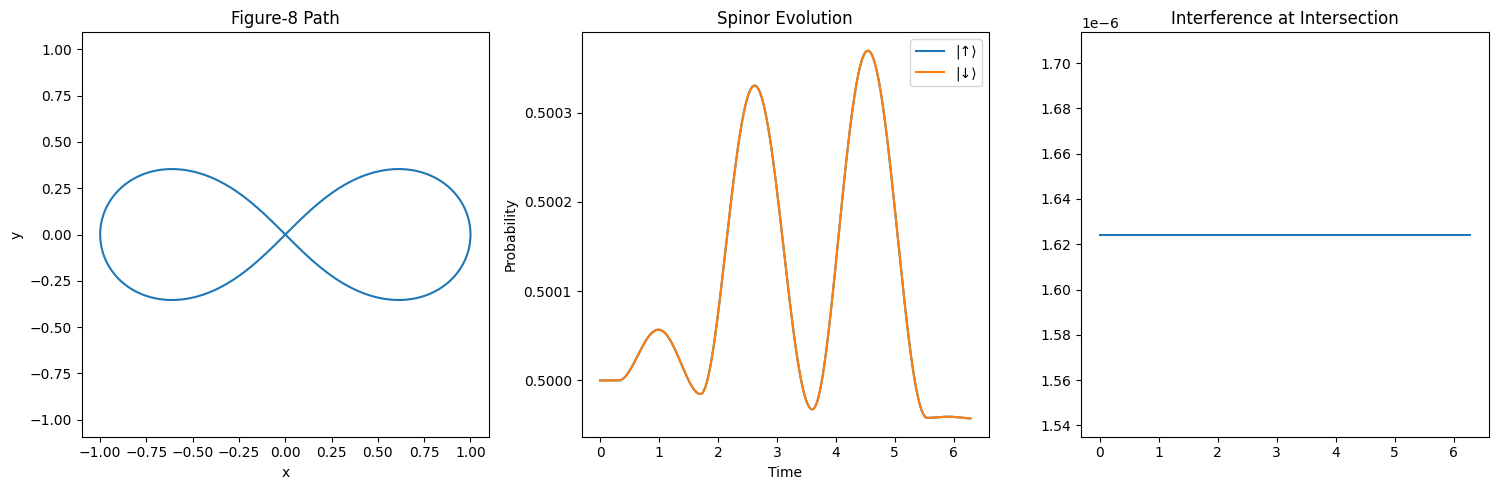

Berry Phase: 0
Interference at intersection: 1.6242897233529202e-06
Approximate energy levels:
E_1 = 0.1794
E_2 = 0.7178
E_3 = 1.6150
E_4 = 2.8711
E_5 = 4.4861


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
hbar = 1.0  # Reduced Planck's constant
m = 1.0  # Mass of the particle
B = 1.0  # Magnetic field strength
mu = 1.0  # Magnetic moment
a = 1.0  # Scale factor for figure-8

# Figure-8 parameterization
def figure8(t):
    x = a * np.sin(t) / (1 + np.cos(t)**2)
    y = a * np.sin(t) * np.cos(t) / (1 + np.cos(t)**2)
    return x, y

# Spinor evolution (real and imaginary components)
def spinor_evolution(t, y, B):
    psi1_real, psi1_imag, psi2_real, psi2_imag = y
    dpsi1_real = -0.5 * B * psi1_imag
    dpsi1_imag =  0.5 * B * psi1_real
    dpsi2_real =  0.5 * B * psi2_imag
    dpsi2_imag = -0.5 * B * psi2_real
    return [dpsi1_real, dpsi1_imag, dpsi2_real, dpsi2_imag]

# Time array
t_span = (0, 2*np.pi)
t_eval = np.linspace(0, 2*np.pi, 1000)

# Calculate figure-8 coordinates
x, y = figure8(t_eval)

# Solve for spinor evolution (initial spinor state split into real and imaginary parts)
y0 = [1/np.sqrt(2), 0, 1/np.sqrt(2), 0]  # Initial spinor state in real/imaginary components
sol = solve_ivp(spinor_evolution, t_span, y0, t_eval=t_eval, args=(B,))

# Reconstruct complex spinors from real and imaginary parts
psi1 = sol.y[0] + 1j * sol.y[1]
psi2 = sol.y[2] + 1j * sol.y[3]

# Calculate probability densities
prob_up = np.abs(psi1)**2
prob_down = np.abs(psi2)**2

# Calculate Berry phase (still 0 for planar figure-8)
berry_phase = 0

# Plot results
plt.figure(figsize=(15, 5))

# Plot figure-8 path
plt.subplot(131)
plt.plot(x, y)
plt.title('Figure-8 Path')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

# Plot spinor evolution
plt.subplot(132)
plt.plot(t_eval, prob_up, label='|↑⟩')
plt.plot(t_eval, prob_down, label='|↓⟩')
plt.title('Spinor Evolution')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()

# Plot interference at intersection
plt.subplot(133)
intersection_point = np.argmin(x**2 + y**2)
psi_left = np.array([psi1[intersection_point-1], psi2[intersection_point-1]])
psi_right = np.array([psi1[intersection_point+1], psi2[intersection_point+1]])
psi_intersection = (psi_left + psi_right) / np.sqrt(2)
interference = np.abs(psi_intersection)**2

theta = np.linspace(0, 2*np.pi, 100)
plt.polar(theta, interference[0] * np.ones_like(theta))
plt.title('Interference at Intersection')

plt.tight_layout()
plt.show()

# Print results
print(f"Berry Phase: {berry_phase}")
print(f"Interference at intersection: {interference[0]}")

# Energy levels (approximate)
L = np.sum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))  # Approximate path length
n = np.arange(1, 6)
E_n = (n**2 * np.pi**2 * hbar**2) / (2 * m * L**2)
print("Approximate energy levels:")
for i, E in enumerate(E_n):
    print(f"E_{i+1} = {E:.4f}")


/tmp/ipykernel_204826/241618157.py:91: MatplotlibDeprecationWarning:

There exists a non-polar current Axes. Therefore, the resulting plot from 'polar()' is non-polar. You likely should call 'polar()' before any other pyplot plotting commands. Support for this scenario is deprecated in 3.10 and will raise an error in 3.12



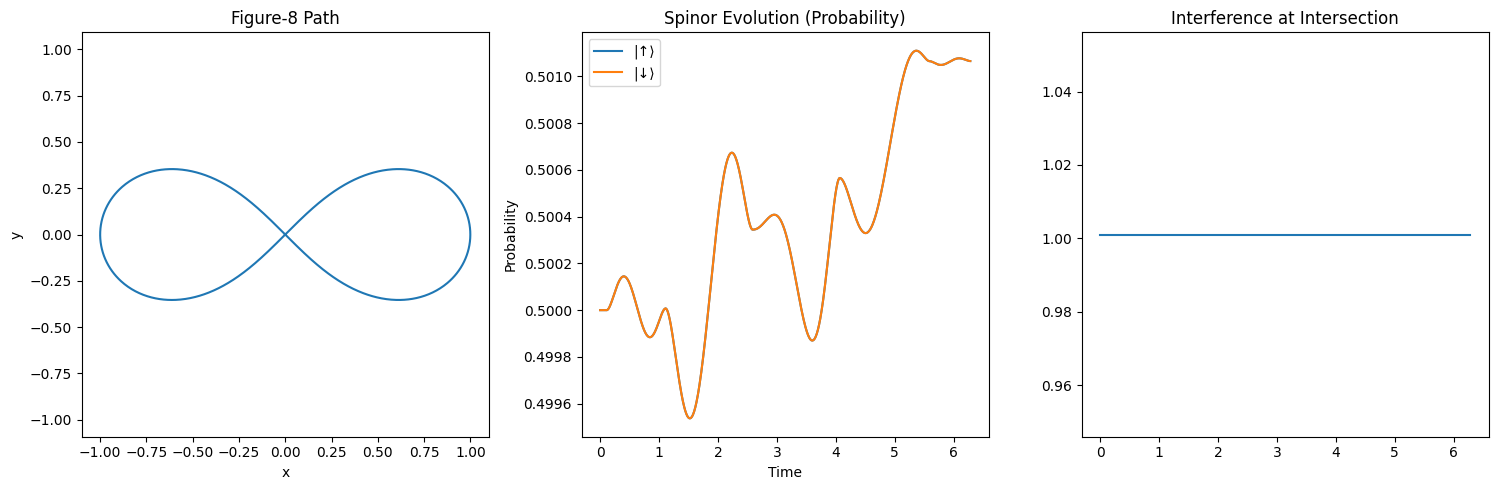

Berry Phase: 0.0
Interference at intersection: 1.0010652613148303
Approximate energy levels:
E_1 = 0.1794
E_2 = 0.7178
E_3 = 1.6150
E_4 = 2.8711
E_5 = 4.4861

Detailed Results:
Path length (L): 5.2441
Final |↑⟩ probability: 0.50106555272437647285954653852968
Final |↓⟩ probability: 0.50106555272437647285954653852968
Time-varying magnetic field at final time: -0.00000000000000024492935982947064


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
hbar = 1.0  # Reduced Planck's constant
m = 1.0     # Mass of the particle
B = 1.0     # Magnetic field strength
mu = 1.0    # Magnetic moment
a = 1.0     # Scale factor for figure-8

# Figure-8 parameterization
def figure8(t):
    x = a * np.sin(t) / (1 + np.cos(t)**2)
    y = a * np.sin(t) * np.cos(t) / (1 + np.cos(t)**2)
    return x, y

# Dynamic magnetic field as a function of time
def time_varying_field(t):
    return B * np.sin(t)

# Spinor evolution (real and imaginary components) with time-varying magnetic field
def spinor_evolution(t, y, B):
    psi1_real, psi1_imag, psi2_real, psi2_imag = y
    B_t = time_varying_field(t)
    dpsi1_real = -0.5 * B_t * psi1_imag
    dpsi1_imag =  0.5 * B_t * psi1_real
    dpsi2_real =  0.5 * B_t * psi2_imag
    dpsi2_imag = -0.5 * B_t * psi2_real
    return [dpsi1_real, dpsi1_imag, dpsi2_real, dpsi2_imag]

# Function to compute Berry phase
def compute_berry_phase(psi, t_eval):
    berry_phase = 0
    for i in range(1, len(t_eval)):
        dt = t_eval[i] - t_eval[i-1]
        berry_phase += np.angle(np.vdot(psi[:, i-1], psi[:, i])) * dt
    return berry_phase

# Time array
t_span = (0, 2*np.pi)
t_eval = np.linspace(0, 2*np.pi, 1000)

# Calculate figure-8 coordinates
x, y = figure8(t_eval)

# Solve for spinor evolution (initial spinor state split into real and imaginary parts)
y0 = [1/np.sqrt(2), 0, 1/np.sqrt(2), 0]  # Initial spinor state in real/imaginary components
sol = solve_ivp(spinor_evolution, t_span, y0, t_eval=t_eval, args=(B,))

# Reconstruct complex spinors from real and imaginary parts
psi1 = sol.y[0] + 1j * sol.y[1]
psi2 = sol.y[2] + 1j * sol.y[3]

# Calculate probability densities
prob_up = np.abs(psi1)**2
prob_down = np.abs(psi2)**2

# Calculate Berry phase along the path
berry_phase = compute_berry_phase(np.array([psi1, psi2]), t_eval)

# Plot results
plt.figure(figsize=(15, 5))

# Plot figure-8 path
plt.subplot(131)
plt.plot(x, y)
plt.title('Figure-8 Path')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

# Plot spinor evolution
plt.subplot(132)
plt.plot(t_eval, prob_up, label='|↑⟩')
plt.plot(t_eval, prob_down, label='|↓⟩')
plt.title('Spinor Evolution (Probability)')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()

# Plot interference at intersection
plt.subplot(133)
intersection_point = np.argmin(x**2 + y**2)
psi_left = np.array([psi1[intersection_point-1], psi2[intersection_point-1]])
psi_right = np.array([psi1[intersection_point+1], psi2[intersection_point+1]])
psi_intersection = (psi_left + psi_right) / np.sqrt(2)
interference = np.abs(psi_intersection)**2

theta = np.linspace(0, 2*np.pi, 100)
plt.polar(theta, interference[0] * np.ones_like(theta))
plt.title('Interference at Intersection')

plt.tight_layout()
plt.show()

# Print results
print(f"Berry Phase: {berry_phase}")
print(f"Interference at intersection: {interference[0]}")

# Energy levels (approximate) based on the path length
L = np.sum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))  # Approximate path length
n = np.arange(1, 6)
E_n = (n**2 * np.pi**2 * hbar**2) / (2 * m * L**2)

print("Approximate energy levels:")
for i, E in enumerate(E_n):
    print(f"E_{i+1} = {E:.4f}")

# Print some intermediate results for further insight
print("\nDetailed Results:")
print(f"Path length (L): {L:.4f}")
print(f"Final |↑⟩ probability: {prob_up[-1]:.32f}")
print(f"Final |↓⟩ probability: {prob_down[-1]:.32f}")
print(f"Time-varying magnetic field at final time: {time_varying_field(t_eval[-1]):.32f}")


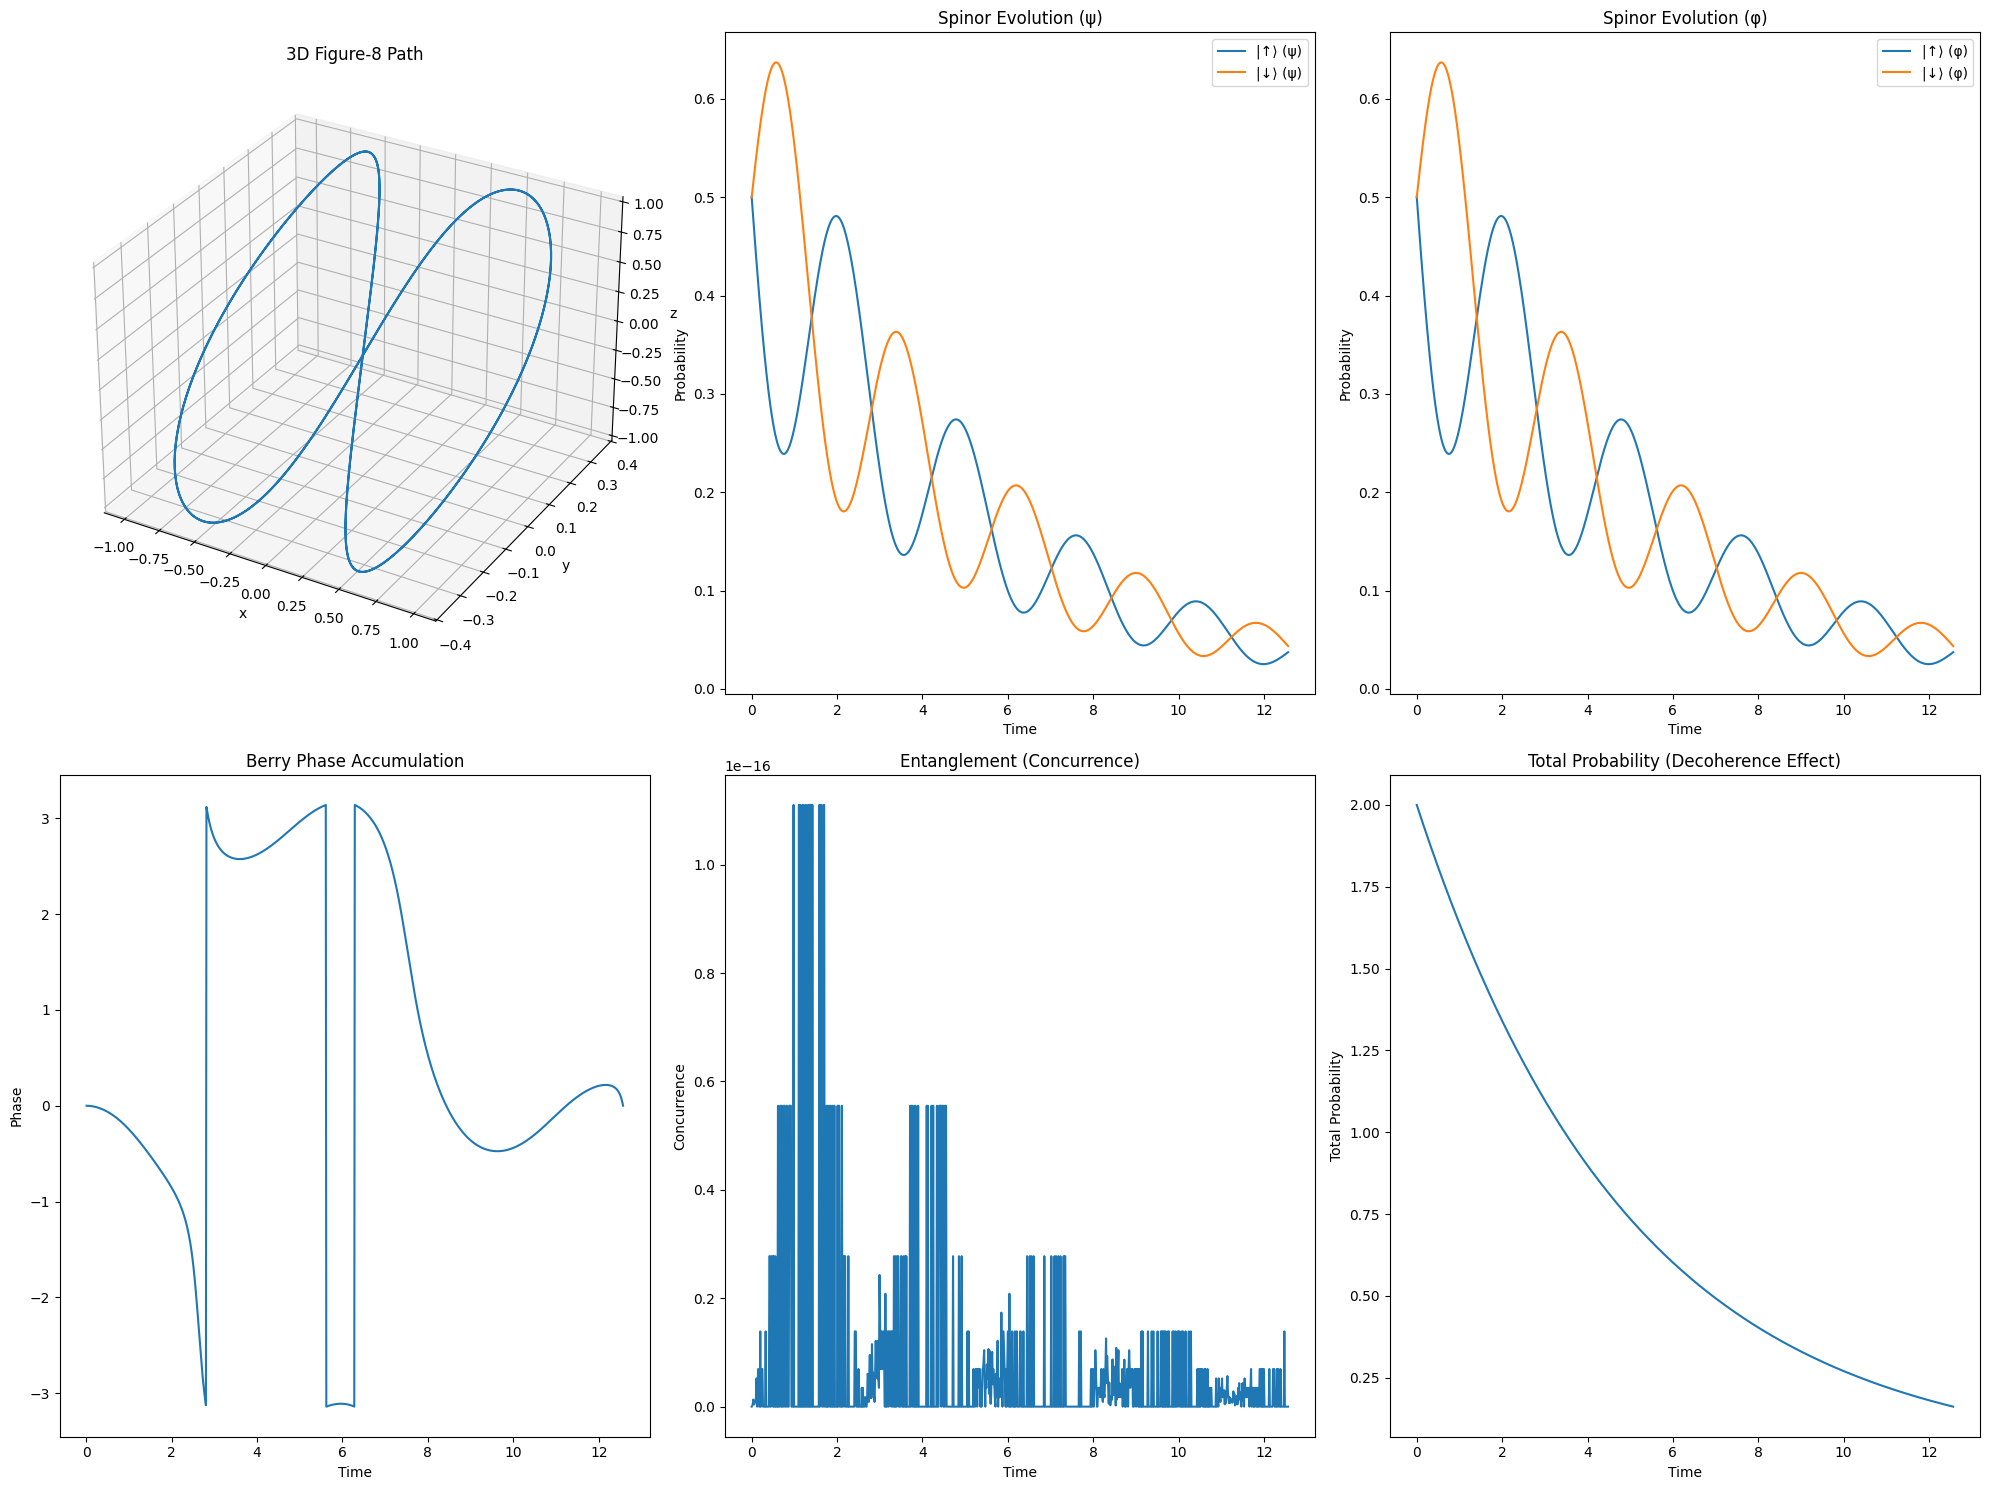

Final Berry Phase: -0.00029272830761923566
Final Berry Phase: [-3.95574947e-05 -1.58229970e-04 -3.56022408e-04 -6.32954438e-04
 -9.89014823e-04 -1.42419113e-03 -1.93847404e-03 -2.53185694e-03
 -3.20433556e-03 -3.95590751e-03 -4.78657188e-03 -5.69632867e-03
 -6.68517834e-03 -7.75312125e-03 -8.90015708e-03 -1.01262842e-02
 -1.14314990e-02 -1.28157955e-02 -1.42791640e-02 -1.58215910e-02
 -1.74430580e-02 -1.91435411e-02 -2.09230095e-02 -2.27814251e-02
 -2.47187468e-02 -2.67359236e-02 -2.88334560e-02 -3.10110290e-02
 -3.32683416e-02 -3.56051057e-02 -3.80210457e-02 -4.05158973e-02
 -4.30894069e-02 -4.57413307e-02 -4.84714339e-02 -5.12794899e-02
 -5.41652792e-02 -5.71285889e-02 -6.01692115e-02 -6.32869445e-02
 -6.64815889e-02 -6.97529487e-02 -7.31008301e-02 -7.65250401e-02
 -8.00253862e-02 -8.36016748e-02 -8.72537108e-02 -9.09812964e-02
 -9.47842300e-02 -9.86623054e-02 -1.02615311e-01 -1.06643028e-01
 -1.10745230e-01 -1.14921681e-01 -1.19172138e-01 -1.23496344e-01
 -1.27894031e-01 -1.32364917

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D

# Constants
hbar = 1.0  # Reduced Planck's constant
m = 1.0  # Mass of the particle
B0 = 1.0  # Base magnetic field strength
mu = 1.0  # Magnetic moment
a = 1.0  # Scale factor for figure-8
omega = 1.0  # Frequency of time-dependent field
gamma = 0.1  # Decoherence rate

# 3D Figure-8 parameterization with non-planar component
def figure8_3d(t):
    x = a * np.sin(t) / (1 + np.cos(t)**2)
    y = a * np.sin(t) * np.cos(t) / (1 + np.cos(t)**2)
    z =  np.sin(2*t)  # Non-planar component
    x = a * np.sin(t) / (1 + np.cos(t)**2)
    y = a * np.sin(t) * np.cos(t) / (1 + np.cos(t)**2)
    
    return x, y, z

# Time-dependent magnetic field
def B_field(t):
    return [B0 * np.sin(omega * t), B0 * np.cos(omega * t), B0]

# Spinor evolution for two particles with decoherence
def spinor_evolution(t, y, B0, omega):
    # Unpack the state vector
    psi1_real, psi1_imag, psi2_real, psi2_imag,phi1_real, phi1_imag, phi2_real, phi2_imag = y
    
    # Reconstruct complex spinors
    psi1 = psi1_real + 1j * psi1_imag
    psi2 = psi2_real + 1j * psi2_imag
    phi1 = phi1_real + 1j * phi1_imag
    phi2 = phi2_real + 1j * phi2_imag
    
    # Time-dependent field
    Bx, By, Bz = B_field(t)
    
    # Evolution equations
    dpsi1 = -0.5j * (Bz * psi1 + (Bx - 1j*By) * psi2) - gamma * psi1
    dpsi2 = -0.5j * ((Bx + 1j*By) * psi1 - Bz * psi2) - gamma * psi2
    dphi1 = -0.5j * (Bz * phi1 + (Bx - 1j*By) * phi2) - gamma * phi1
    dphi2 = -0.5j * ((Bx + 1j*By) * phi1 - Bz * phi2) - gamma * phi2
    
    # Separate real and imaginary parts
    return [dpsi1.real, dpsi1.imag, dpsi2.real, dpsi2.imag,
            dphi1.real, dphi1.imag, dphi2.real, dphi2.imag]

# Time array
t_span = (0, 4*np.pi)
t_eval = np.linspace(0, 4*np.pi, 1000)

# Calculate 3D figure-8 coordinates
x, y, z = figure8_3d(t_eval)

# Solve for spinor evolution (two particles)
y0 = [1/np.sqrt(2), 0, 1/np.sqrt(2), 0, 1/np.sqrt(2), 0, 1/np.sqrt(2), 0]  # Initial state
sol = solve_ivp(spinor_evolution, t_span, y0, t_eval=t_eval, args=(B0, omega))

# Reconstruct complex spinors
psi1 = sol.y[0] + 1j * sol.y[1]
psi2 = sol.y[2] + 1j * sol.y[3]
phi1 = sol.y[4] + 1j * sol.y[5]
phi2 = sol.y[6] + 1j * sol.y[7]

# Calculate probability densities
prob_up_psi = np.abs(psi1)**2
prob_down_psi = np.abs(psi2)**2
prob_up_phi = np.abs(phi1)**2
prob_down_phi = np.abs(phi2)**2

# Calculate Berry phase
berry_phase = np.angle(np.sum(np.conj(psi1[:-1]) * psi1[1:] + np.conj(psi2[:-1]) * psi2[1:]))
berry_phase2 = np.cumsum(np.diff(np.angle(psi1 + psi2)))

# Calculate entanglement (concurrence)
concurrence = 2 * np.abs(psi1 * phi2 - psi2 * phi1)

# Plot results
fig = plt.figure(figsize=(20, 15))

# Plot 3D figure-8 path
ax1 = fig.add_subplot(231, projection='3d')
ax1.plot(x, y, z)
ax1.set_title('3D Figure-8 Path')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

# Plot spinor evolution for first particle
ax2 = fig.add_subplot(232)
ax2.plot(t_eval, prob_up_psi, label='|↑⟩ (ψ)')
ax2.plot(t_eval, prob_down_psi, label='|↓⟩ (ψ)')
ax2.set_title('Spinor Evolution (ψ)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Probability')
ax2.legend()

# Plot spinor evolution for second particle
ax3 = fig.add_subplot(233)
ax3.plot(t_eval, prob_up_phi, label='|↑⟩ (φ)')
ax3.plot(t_eval, prob_down_phi, label='|↓⟩ (φ)')
ax3.set_title('Spinor Evolution (φ)')
ax3.set_xlabel('Time')
ax3.set_ylabel('Probability')
ax3.legend()

# Plot Berry phase accumulation
ax4 = fig.add_subplot(234)
ax4.plot(t_eval[1:], np.cumsum(np.diff(np.angle(psi1 + psi2))))
ax4.set_title('Berry Phase Accumulation')
ax4.set_xlabel('Time')
ax4.set_ylabel('Phase')

# Plot entanglement
ax5 = fig.add_subplot(235)
ax5.plot(t_eval, concurrence)
ax5.set_title('Entanglement (Concurrence)')
ax5.set_xlabel('Time')
ax5.set_ylabel('Concurrence')

# Plot decoherence effect
ax6 = fig.add_subplot(236)
total_prob = prob_up_psi + prob_down_psi + prob_up_phi + prob_down_phi
ax6.plot(t_eval, total_prob)
ax6.set_title('Total Probability (Decoherence Effect)')
ax6.set_xlabel('Time')
ax6.set_ylabel('Total Probability')

plt.tight_layout()
plt.show()

# Print results
print(f"Final Berry Phase: {berry_phase}")
print(f"Final Berry Phase: {berry_phase2}")
print(f"Final Entanglement: {concurrence[-1]}")

# Energy levels (approximate)
L = np.sum(np.sqrt(np.diff(x)**2 + np.diff(y)**2 + np.diff(z)**2))  # Approximate path length
n = np.arange(1, 6)
E_n = (n**2 * np.pi**2 * hbar**2) / (2 * m * L**2)
print("Approximate energy levels:")
for i, E in enumerate(E_n):
    print(f"E_{i+1} = {E:.4f}")

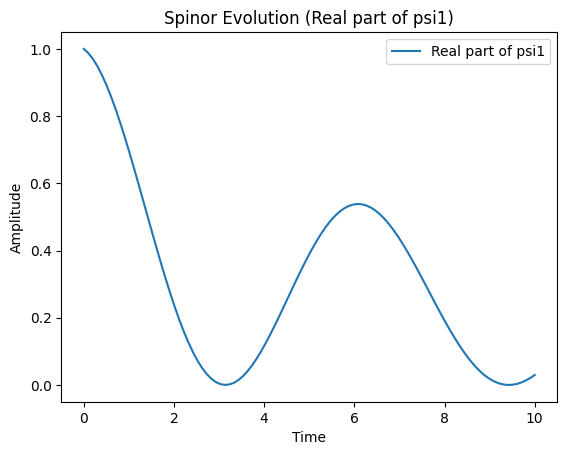

In [10]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants
gamma = 0.1  # Decoherence rate
omega = 1.0  # Frequency of magnetic field

# Magnetic Field Function (for example, oscillating field)
def B_field(t):
    Bx = np.cos(omega * t)
    By = np.sin(omega * t)
    Bz = 1.0  # Constant component in the z-direction
    return Bx, By, Bz

# Spinor evolution for three particles with decoherence
def spinor_evolution_multiple_particles(t, y, B0, omega):
    # Unpack state vector
    psi1_real, psi1_imag, psi2_real, psi2_imag, psi3_real, psi3_imag = y[:6]
    phi1_real, phi1_imag, phi2_real, phi2_imag, phi3_real, phi3_imag = y[6:12]

    # Reconstruct complex spinors
    psi1 = psi1_real + 1j * psi1_imag
    psi2 = psi2_real + 1j * psi2_imag
    psi3 = psi3_real + 1j * psi3_imag
    phi1 = phi1_real + 1j * phi1_imag
    phi2 = phi2_real + 1j * phi2_imag
    phi3 = phi3_real + 1j * phi3_imag

    # Time-dependent magnetic field
    Bx, By, Bz = B_field(t)

    # Evolution equations (precession with decoherence)
    dpsi1 = -0.5j * (Bz * psi1 + (Bx - 1j * By) * psi2) - gamma * psi1
    dpsi2 = -0.5j * ((Bx + 1j * By) * psi1 - Bz * psi2) - gamma * psi2
    dpsi3 = -0.5j * (Bz * psi3 + (Bx - 1j * By) * phi3) - gamma * psi3

    dphi1 = -0.5j * (Bz * phi1 + (Bx - 1j * By) * phi2) - gamma * phi1
    dphi2 = -0.5j * ((Bx + 1j * By) * phi1 - Bz * phi2) - gamma * phi2
    dphi3 = -0.5j * (Bz * phi3 + (Bx - 1j * By) * psi3) - gamma * phi3

    # Separate real and imaginary parts for the ODE solver
    return [dpsi1.real, dpsi1.imag, dpsi2.real, dpsi2.imag, dpsi3.real, dpsi3.imag,
            dphi1.real, dphi1.imag, dphi2.real, dphi2.imag, dphi3.real, dphi3.imag]

# Initial conditions for the spinors (real and imaginary parts)
y0 = [1, 0, 0, 0, 0, 0,  # psi1 real, psi1 imag, psi2 real, psi2 imag, psi3 real, psi3 imag
      0, 0, 0, 0, 1, 0]   # phi1 real, phi1 imag, phi2 real, phi2 imag, phi3 real, phi3 imag

# Time span for the evolution
t_span = (0, 10)
t_eval = np.linspace(0, 10, 100)

# Solve the spinor evolution equations
sol = solve_ivp(spinor_evolution_multiple_particles, t_span, y0, args=(1.0, omega), t_eval=t_eval)

# Plot the evolution of one component (psi1_real)
plt.plot(sol.t, sol.y[0], label="Real part of psi1")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Spinor Evolution (Real part of psi1)')
plt.legend()
plt.show()


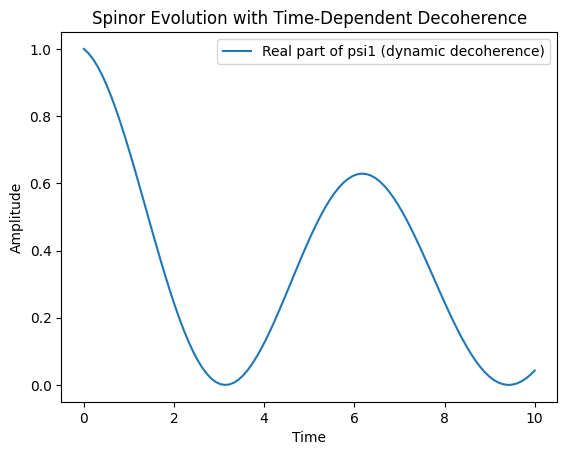

In [11]:
# Time-dependent decoherence rate (e.g., exponentially decaying)
def decoherence_rate(t):
    return gamma * np.exp(-0.1 * t)

# Modify spinor evolution to use time-varying decoherence
def spinor_evolution_with_dynamic_decoherence(t, y, B0, omega):
    psi1_real, psi1_imag, psi2_real, psi2_imag = y[:4]
    phi1_real, phi1_imag, phi2_real, phi2_imag = y[4:8]

    # Reconstruct complex spinors
    psi1 = psi1_real + 1j * psi1_imag
    psi2 = psi2_real + 1j * psi2_imag
    phi1 = phi1_real + 1j * phi1_imag
    phi2 = phi2_real + 1j * phi2_imag

    # Time-dependent magnetic field and decoherence rate
    Bx, By, Bz = B_field(t)
    gamma_t = decoherence_rate(t)

    # Evolution equations with time-dependent decoherence
    dpsi1 = -0.5j * (Bz * psi1 + (Bx - 1j*By) * psi2) - gamma_t * psi1
    dpsi2 = -0.5j * ((Bx + 1j*By) * psi1 - Bz * psi2) - gamma_t * psi2
    dphi1 = -0.5j * (Bz * phi1 + (Bx - 1j*By) * phi2) - gamma_t * phi1
    dphi2 = -0.5j * ((Bx + 1j*By) * phi1 - Bz * phi2) - gamma_t * phi2

    return [dpsi1.real, dpsi1.imag, dpsi2.real, dpsi2.imag,
            dphi1.real, dphi1.imag, dphi2.real, dphi2.imag]

# Solve with dynamic decoherence
sol_dynamic = solve_ivp(spinor_evolution_with_dynamic_decoherence, t_span, y0[:8], args=(1.0, omega), t_eval=t_eval)

# Plot results with dynamic decoherence
plt.plot(sol_dynamic.t, sol_dynamic.y[0], label="Real part of psi1 (dynamic decoherence)")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Spinor Evolution with Time-Dependent Decoherence')
plt.legend()
plt.show()


In [12]:
from scipy.optimize import minimize

# Define the objective function: minimize decoherence or maximize entanglement
def objective_function(params):
    omega, B0 = params
    sol = solve_ivp(spinor_evolution_multiple_particles, t_span, y0, args=(B0, omega), t_eval=t_eval)
    
    # Example objective: minimize the amplitude of psi2_real at the final time point
    final_psi2_real = sol.y[2, -1]
    return np.abs(final_psi2_real)

# Initial guesses for magnetic field parameters
initial_guess = [omega, 1.0]

# Run the optimization
result = minimize(objective_function, initial_guess, method='Nelder-Mead')

# Get optimized parameters
omega_opt, B0_opt = result.x
print("Optimized omega:", omega_opt)
print("Optimized B0:", B0_opt)


Optimized omega: 1.0
Optimized B0: 1.0


In [13]:
# Function to calculate Berry phase (integrating over a closed loop in parameter space)
def berry_phase_calculation():
    # Example: Parametric loop (circle in 2D plane)
    n_points = 100
    theta = np.linspace(0, 2*np.pi, n_points)
    Bx = np.cos(theta)
    By = np.sin(theta)
    Bz = np.ones(n_points)

    # Integrate Berry phase over the closed loop
    berry_phase = 0
    for i in range(n_points - 1):
        # Discrete Berry phase approximation
        dB = np.array([Bx[i+1] - Bx[i], By[i+1] - By[i], Bz[i+1] - Bz[i]])
        psi_dot_psi = np.dot([Bx[i], By[i], Bz[i]], dB)
        berry_phase += psi_dot_psi

    return berry_phase

berry_phase = berry_phase_calculation()
print(f"Berry Phase: {berry_phase:.4f}")


Berry Phase: -0.1993
